# Get counts from Google N-grams
It will be useful to have a baseline, long-term level of integration to expect, which we can compare to the social media and newspaper counts.

Let's query Google N-grams to get this integration ratio. We'll use [this library](https://github.com/econpy/google-ngrams).

In [2]:
import sys
if('google-ngrams' not in sys.path):
    sys.path.append('google-ngrams')
from getngrams import getNgrams

In [127]:
from time import sleep
# # test query
# import pandas as pd
def extract_ngram_counts(query, corpus='spa_2012', start_year=1980, end_year=2012, smooth=3, verbose=False):
    success = False
    MAX_QUERY_COUNT = 2
    QUERY_SLEEP_TIME = 600 # min sleep time = 10 mins?? 103*5 sec = 515 sec ~ 10 min
    query_ctr = 0
    while(not success and query_ctr < MAX_QUERY_COUNT):
        query_results = getNgrams(query, corpus, start_year, end_year, smooth, caseInsensitive=True)
        # empty data => failed search (because rate limit?)
        success = query_results[2].shape[0]!=0
        if(not success):
            if(verbose):
                print(f'bad query, sleeping for {QUERY_SLEEP_TIME} sec')
            sleep(QUERY_SLEEP_TIME)
            query_ctr += 1
    if(verbose):
        print(f'results={query_results}')
    query_counts = query_results[2]
    year_col = 'year'
    # if no results, add 0 counts
    NULL_COUNT = 0.
    if(query_counts.shape[0] == 0):
        year_range = list(range(start_year, end_year+1))
        query_counts = query_counts.assign(**{
            year_col : year_range
        })
    if(query_counts.shape[1] == 1):
        query_counts = query_counts.assign(**{
            query : NULL_COUNT
        })
        
    # restrict to combined query
    # either (All) or _INF (infinitive)
    elif(query_counts.shape[1] > 2):
        query_col = list(filter(lambda x: '(All)' in x or '_INF' in x, query_counts.columns))[0]
        query_counts = query_counts.loc[:, [year_col, query_col]]
    # fix column names
    # e.g. "Aimeé" gets hits but not "aimeé"
    query_counts.columns = [year_col, query]
    if(verbose):
        print(query_counts.head())
    # reshape to be less dumb
    query_counts = pd.melt(query_counts, value_vars=[query], id_vars=[year_col], value_name='count', var_name='query')
    return query_counts

In [128]:
query_1 = 'cliquear'
query_2 = 'hacer_INF clic'
query_counts_1 = extract_ngram_counts(query_1)
query_counts_2 = extract_ngram_counts(query_2)
query_counts_combined = pd.concat([query_counts_1, query_counts_2], axis=0)
display(query_counts_combined)
# corpus = 'spa_2012'
# start_year = 1980
# end_year = 2012
# smooth = 3
# query_counts_1 = getNgrams(query_1, corpus, start_year, end_year, smooth, caseInsensitive=True)[2]
# query_counts_2 = getNgrams(query_2, corpus, start_year, end_year, smooth, caseInsensitive=True)[2]
# a = pd.melt(query_counts_1, value_vars=[query_1], id_vars=['year'], value_name='count', var_name='query')
# display(a.head())
# query_counts_1 = query_counts_1.assign(**{'query':query_1})
# query_counts_2 = query_counts_2.assign(**{'query':query_2})
# query_counts_combined = pd.concat([query_counts_1, query_counts_2], axis=0)
# display(query_counts_combined.head())

,year,query,count
0,1980,cliquear,2.431216e-10
1,1981,cliquear,1.944973e-10
2,1982,cliquear,1.620811e-10
3,1983,cliquear,1.389266e-10
4,1984,cliquear,0.000000e+00
...,...,...,...
28,2008,hacer_INF clic,4.767662e-06
29,2009,hacer_INF clic,3.805918e-06
30,2010,hacer_INF clic,3.863161e-06
31,2011,hacer_INF clic,3.288264e-06


### Collect loanword query counts and native verb query counts

In [121]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import conjugate_verb, conjugate_light_verb
import pandas as pd
loanword_verb_query_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_integrated_verbs_light_verbs.tsv', sep='\t')
native_verb_query_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv', sep=',')
# combine
loanword_verb_query_data.rename(columns={'loanword' : 'word'}, inplace=True)
native_verb_query_data = native_verb_query_data.assign(**{
    'word' : native_verb_query_data.loc[:, 'integrated_verb'].values
})
loanword_verb_query_data = loanword_verb_query_data.assign(**{
    'word_type' : 'loanword',
})
native_verb_query_data = native_verb_query_data.assign(**{
    'word_type' : 'native_verb',
})
combined_query_data = pd.concat([loanword_verb_query_data, native_verb_query_data])
# conjugate integrated, light verbs
combined_query_data = combined_query_data.assign(**{
    'integrated_verb_queries' : combined_query_data.loc[:, 'integrated_verb'].apply(conjugate_verb)
})
# filter ambiguous verb forms
ambiguous_integrated_verbs = ['accesar', 'auditar', 'boxear', 'chequear', 'formear', 'frizar']
for verb_i in ambiguous_integrated_verbs:
    verb_forms_i = [verb_i.replace('ar', 'o'), verb_i.replace('ar', 'a')]
    data_i = combined_query_data[combined_query_data.loc[:, 'integrated_verb']==verb_i]
    data_i = data_i.assign(**{
        'integrated_verb_queries' : list(filter(lambda x: x not in verb_forms_i, data_i.loc[:, 'integrated_verb_queries']))
    })
combined_query_data = combined_query_data.assign(**{
    'light_verb_queries' : combined_query_data.loc[:, 'light_verb'].apply(conjugate_light_verb)
})
# get clean light verb queries
# hago acces => hacer_INF acces
# faster queries!!
combined_query_data = combined_query_data.assign(**{
    'light_verb_queries_INF' : combined_query_data.loc[:, 'light_verb'].apply(lambda x: conjugate_light_verb(x, add_inf=True))
})
display(combined_query_data.head())

,word,integrated_verb,light_verb,word_type,integrated_verb_queries,light_verb_queries,light_verb_queries_INF
0,access,accesar,hacer|tener acces,loanword,"[accesé, accesamos, accesaste, accesasteis, ac...","[hice acces, hicimos acces, hiciste acces, hic...","[hacer_INF acces, tener_INF acces]"
1,aim,aimear,hacer|tener aim,loanword,"[aimeé, aimeamos, aimeaste, aimeasteis, aimeó,...","[hice aim, hicimos aim, hiciste aim, hicisteis...","[hacer_INF aim, tener_INF aim]"
2,alert,alertear,hacer alert,loanword,"[alerteé, alerteamos, alerteaste, alerteasteis...","[hice alert, hicimos alert, hiciste alert, hic...",[hacer_INF alert]
3,audit,auditar,hacer (un) audit,loanword,"[audité, auditamos, auditaste, auditasteis, au...","[hice audit, hice un audit, hicimos audit, ...","[hacer_INF audit, hacer_INF un audit]"
4,ban,banear,hacer un ban,loanword,"[baneé, baneamos, baneaste, baneasteis, baneó,...","[hice un ban, hicimos un ban, hiciste un ban, ...",[hacer_INF un ban]


Now let's query! This could take a few minutes.

In [94]:
def query_all_forms(query_list, verbose=False):
    """
    Query for each phrase form, then combine total counts per-year.
    """
    combined_query_counts = []
    corpus = 'spa_2012'
    start_year = 1980
    end_year = 2008 # 2008-2012 shows decline for all words...bad
    smooth = 3
    for query in query_list:
        query_counts = extract_ngram_counts(query, corpus=corpus, start_year=start_year, end_year=end_year, smooth=smooth, verbose=verbose)
        combined_query_counts.append(query_counts)
    combined_query_counts = pd.concat(combined_query_counts, axis=0)
    time_var = 'year'
    count_var = 'count'
    agg_query_counts = combined_query_counts.groupby(time_var).apply(lambda x: x.loc[:, count_var].sum())
    return agg_query_counts

In [129]:
from time import sleep
# query_list = combined_query_data.loc[:, 'integrated_verb_queries'].iloc[0]
# agg_query_counts = query_all_forms(query_list, verbose=False)
def query_and_clean(data, query_col='integrated_verb_queries', query_verb_type='integrated_verb', verbose=False):
    query_data = query_all_forms(data.loc[query_col], verbose=verbose)
    query_data = query_data.reset_index().rename(columns={0:'count'}).assign(**{'query': data.loc['word'], 'verb_type' : query_verb_type})
    return query_data

In [ ]:
agg_query_counts = combined_query_data.apply(lambda x: query_and_clean(x, verbose=True), axis=1)
display(agg_query_counts.head())

results=('https://books.google.com/ngrams/graph?content=acces%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'accesé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  accesé
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=accesamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Caccesamos%3B%2Cc0', 'accesamos',     year     accesamos
0   1980  0.000000e+00
1   1981  0.000000e+00
2   1982  0.000000e+00
3   1983  0.000000e+00
4   1984  0.000000e+00
5   1985  1.096945e-10
6   1986  1.096945e-10
7   1987  1.096945e-10
8   1988  1.096945e-10
9   1989  1.096945e-10
10  1990  1.096945e-10

results=('https://books.google.com/ngrams/graph?content=acces%C3%A1is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'accesáis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  accesáis
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=accesa&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Caccesa%3B%2Cc0%3B%2Cs0%3B%3Baccesa%3B%2Cc0%3B%3BAccesa%3B%2Cc0', 'accesa',     year  accesa (All)        accesa        Accesa
0   1980  4.632523e-09  4.632523e-09  0.000000e+00
1   1981  6.099202e-09  5.915110e-09  1.840910e-10
2   1982  6.575492e-09  6.123518e-09  4.519739e-10
3   1983  7.8412

results=('https://books.google.com/ngrams/graph?content=acces%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'accesé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  accesé
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=accesamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Caccesamos%3B%2Cc0', 'accesamos',     year     accesamos
0   1980  0.000000e+00
1   1981  0.000000e+00
2   1982  0.000000e+00
3   1983  0.000000e+00
4   1984  0.000000e+00
5   1985  1.096945e-10
6   1986  1.096945e-10
7   1987  1.096945e-10
8   1988  1.096945e-10
9   1989  1.096945e-10
10  1990  1.096945e-10

results=('https://books.google.com/ngrams/graph?content=acces%C3%A1is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'accesáis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  accesáis
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=accesa&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Caccesa%3B%2Cc0%3B%2Cs0%3B%3Baccesa%3B%2Cc0%3B%3BAccesa%3B%2Cc0', 'accesa',     year  accesa (All)        accesa        Accesa
0   1980  4.632523e-09  4.632523e-09  0.000000e+00
1   1981  6.099202e-09  5.915110e-09  1.840910e-10
2   1982  6.575492e-09  6.123518e-09  4.519739e-10
3   1983  7.8412

results=('https://books.google.com/ngrams/graph?content=aime%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2CAime%C3%A9%3B%2Cc0', 'aimeé',     year         Aimeé
0   1980  1.862193e-09
1   1981  1.489754e-09
2   1982  1.390744e-09
3   1983  2.172107e-09
4   1984  7.509775e-09
5   1985  8.580435e-09
6   1986  1.102498e-08
7   1987  1.121154e-08
8   1988  1.188563e-08
9   1989  1.329738e-08
10  1990  1.275348e-08
11  1991  8.221855e-09
12  1992  8.478510e-09
13  1993  8.072780e-09
14  1994  8.642907e-09
15  1995  9.222825e-09
16  1996  8.488083e-09
17  1997  9.112802e-09
18  1998  9.205020e-09
19  1999  1.010863e-08
20  2000  9.556081e-09
21  2001  1.061510e-08
22  2002  1.154478e-08
23  2003  1.170012e-08
24  2004  1.142527e-08
25  2005  1.063632e-08
26  2006  9.647662e-09
27  2007  9.310494e-09
28  2008  7.798180e-09)
   year         aimeé
0  1980  1.862193e-09
1  1981  1.489754e-09
2  1982  1.390744e-09
3  1983  2.172107e-09
4  1984  

results=('https://books.google.com/ngrams/graph?content=aimear%C3%A9is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'aimearéis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  aimearéis
0  1980        0.0
1  1981        0.0
2  1982        0.0
3  1983        0.0
4  1984        0.0
results=('https://books.google.com/ngrams/graph?content=aimear%C3%A1&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'aimeará',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   y

results=('https://books.google.com/ngrams/graph?content=alertean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'alertean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  alertean
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=alertear%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'alertearé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  aler

results=('https://books.google.com/ngrams/graph?content=auditaron&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cauditaron%3B%2Cc0', 'auditaron',     year     auditaron
0   1980  7.070655e-10
1   1981  1.302016e-09
2   1982  1.682143e-09
3   1983  1.686847e-09
4   1984  1.408994e-09
5   1985  2.176855e-09
6   1986  2.849207e-09
7   1987  3.062086e-09
8   1988  3.210206e-09
9   1989  3.622206e-09
10  1990  5.012708e-09
11  1991  6.948845e-09
12  1992  7.539757e-09
13  1993  7.755794e-09
14  1994  9.425220e-09
15  1995  9.837936e-09
16  1996  9.880071e-09
17  1997  1.029049e-08
18  1998  9.282622e-09
19  1999  9.221826e-09
20  2000  9.069379e-09
21  2001  8.193406e-09
22  2002  7.966840e-09
23  2003  8.166965e-09
24  2004  6.985629e-09
25  2005  6.899124e-09
26  2006  6.534672e-09
27  2007  6.811287e-09
28  2008  6.532206e-09)
   year     auditaron
0  1980  7.070655e-10
1  1981  1.302016e-09
2  1982  1.682143e-09
3  1983  1.686847e-09
4  1984

results=('https://books.google.com/ngrams/graph?content=auditar%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'auditaré',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  auditaré
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=auditaremos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'auditaremos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  

results=('https://books.google.com/ngrams/graph?content=baneasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'baneasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  baneasteis
0  1980         0.0
1  1981         0.0
2  1982         0.0
3  1983         0.0
4  1984         0.0
results=('https://books.google.com/ngrams/graph?content=bane%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'baneó',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   ye

results=('https://books.google.com/ngrams/graph?content=banear%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'banearás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  banearás
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=banear%C3%A9is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'banearéis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year 

results=('https://books.google.com/ngrams/graph?content=bangea&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'bangea',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  bangea
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=bangean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'bangean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  bangean
0  1980      0.0
1  1

results=('https://books.google.com/ngrams/graph?content=basheo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'basheo',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  basheo
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=basheamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'basheamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  basheamos
0  1980        

results=('https://books.google.com/ngrams/graph?content=blockeaste&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'blockeaste',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  blockeaste
0  1980         0.0
1  1981         0.0
2  1982         0.0
3  1983         0.0
4  1984         0.0
results=('https://books.google.com/ngrams/graph?content=blockeasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'blockeasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  20

results=('https://books.google.com/ngrams/graph?content=blockear%C3%A1n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'blockearán',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  blockearán
0  1980         0.0
1  1981         0.0
2  1982         0.0
3  1983         0.0
4  1984         0.0
results=('https://books.google.com/ngrams/graph?content=blockear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'blockear',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)

results=('https://books.google.com/ngrams/graph?content=boicoteamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cboicoteamos%3B%2Cc0', 'boicoteamos',     year   boicoteamos
0   1980  2.769481e-09
1   1981  3.504222e-09
2   1982  3.069467e-09
3   1983  2.998487e-09
4   1984  3.095924e-09
5   1985  3.508417e-09
6   1986  2.956484e-09
7   1987  2.451748e-09
8   1988  1.643642e-09
9   1989  1.926275e-09
10  1990  1.776827e-09
11  1991  1.605341e-09
12  1992  1.683995e-09
13  1993  1.868066e-09
14  1994  2.304694e-09
15  1995  2.777551e-09
16  1996  2.527955e-09
17  1997  2.461438e-09
18  1998  2.799121e-09
19  1999  2.401050e-09
20  2000  2.620080e-09
21  2001  2.537363e-09
22  2002  2.018330e-09
23  2003  2.200303e-09
24  2004  2.756152e-09
25  2005  2.845984e-09
26  2006  3.053084e-09
27  2007  2.942478e-09
28  2008  3.058752e-09)
   year   boicoteamos
0  1980  2.769481e-09
1  1981  3.504222e-09
2  1982  3.069467e-09
3  1983  2.998487e-09
4

results=('https://books.google.com/ngrams/graph?content=boicotear%C3%A1n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cboicotear%C3%A1n%3B%2Cc0', 'boicotearán',     year   boicotearán
0   1980  4.849447e-09
1   1981  5.168195e-09
2   1982  4.754676e-09
3   1983  4.687962e-09
4   1984  5.299616e-09
5   1985  4.948802e-09
6   1986  4.538028e-09
7   1987  3.893944e-09
8   1988  3.310536e-09
9   1989  3.337257e-09
10  1990  3.378936e-09
11  1991  3.647375e-09
12  1992  3.318292e-09
13  1993  2.731301e-09
14  1994  3.404211e-09
15  1995  3.067164e-09
16  1996  2.737071e-09
17  1997  2.537519e-09
18  1998  2.369408e-09
19  1999  2.445760e-09
20  2000  2.542717e-09
21  2001  2.110698e-09
22  2002  2.772424e-09
23  2003  2.760521e-09
24  2004  2.777469e-09
25  2005  2.452659e-09
26  2006  2.772359e-09
27  2007  2.914703e-09
28  2008  3.024034e-09)
   year   boicotearán
0  1980  4.849447e-09
1  1981  5.168195e-09
2  1982  4.754676e-09
3  1983  4.68

results=('https://books.google.com/ngrams/graph?content=boxeamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'boxeamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  boxeamos
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=boxeas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'boxeas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  boxeas
0  1980 

results=('https://books.google.com/ngrams/graph?content=boxear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cboxear%3B%2Cc0%3B%2Cs0%3B%3Bboxear%3B%2Cc0%3B%3BBoxear%3B%2Cc0', 'boxear',     year  boxear (All)        boxear        Boxear
0   1980  5.722593e-08  5.314312e-08  4.082810e-09
1   1981  5.222393e-08  4.895768e-08  3.266248e-09
2   1982  5.456684e-08  5.154640e-08  3.020438e-09
3   1983  5.350935e-08  5.092041e-08  2.588947e-09
4   1984  5.519595e-08  5.224554e-08  2.950407e-09
5   1985  5.679544e-08  5.408615e-08  2.709287e-09
6   1986  5.921989e-08  5.561414e-08  3.605756e-09
7   1987  5.926846e-08  5.638576e-08  2.882693e-09
8   1988  6.320471e-08  6.020967e-08  2.995042e-09
9   1989  6.174243e-08  5.869536e-08  3.047071e-09
10  1990  6.645323e-08  6.231582e-08  4.137413e-09
11  1991  6.561172e-08  6.156709e-08  4.044634e-09
12  1992  6.465455e-08  6.094417e-08  3.710377e-09
13  1993  6.930374e-08  6.589757e-08  3.406167e-09
14  

results=('https://books.google.com/ngrams/graph?content=bulean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'bulean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  bulean
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=bulear%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'bulearé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  bulearé
0  1980      0.0

results=('https://books.google.com/ngrams/graph?content=busteas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'busteas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  busteas
0  1980      0.0
1  1981      0.0
2  1982      0.0
3  1983      0.0
4  1984      0.0
results=('https://books.google.com/ngrams/graph?content=buste%C3%A1is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'busteáis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  busteáis
0  19

results=('https://books.google.com/ngrams/graph?content=caste%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'casteó',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  casteó
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=castearon&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'castearon',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  castearon
0  1980   

results=('https://books.google.com/ngrams/graph?content=castear%C3%A1n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'castearán',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  castearán
0  1980        0.0
1  1981        0.0
2  1982        0.0
3  1983        0.0
4  1984        0.0
results=('https://books.google.com/ngrams/graph?content=castear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'castear',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  

results=('https://books.google.com/ngrams/graph?content=changean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'changean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  changean
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=changear%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'changearé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  chan

results=('https://books.google.com/ngrams/graph?content=chateo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cchateo%3B%2Cc0%3B%2Cs0%3B%3Bchateo%3B%2Cc0%3B%3BChateo%3B%2Cc0', 'chateo',     year  chateo (All)        chateo        Chateo
0   1980  3.244969e-09  3.024146e-09  2.208223e-10
1   1981  5.173249e-09  4.812500e-09  3.607489e-10
2   1982  6.102430e-09  5.801805e-09  3.006241e-10
3   1983  5.598169e-09  5.340491e-09  2.576778e-10
4   1984  6.070896e-09  5.813218e-09  2.576778e-10
5   1985  6.707333e-09  6.449655e-09  2.576778e-10
6   1986  7.898498e-09  7.528761e-09  3.697363e-10
7   1987  7.493619e-09  7.250067e-09  2.435522e-10
8   1988  6.551501e-09  6.439443e-09  1.120586e-10
9   1989  5.734556e-09  5.622498e-09  1.120586e-10
10  1990  5.912212e-09  5.473051e-09  4.391609e-10
11  1991  5.569239e-09  5.028176e-09  5.410629e-10
12  1992  4.775511e-09  4.234448e-09  5.410629e-10
13  1993  3.812298e-09  3.284584e-09  5.277142e-10
14  

results=('https://books.google.com/ngrams/graph?content=chatearemos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'chatearemos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  chatearemos
0  1980          0.0
1  1981          0.0
2  1982          0.0
3  1983          0.0
4  1984          0.0
results=('https://books.google.com/ngrams/graph?content=chatear%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'chatearás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007

results=('https://books.google.com/ngrams/graph?content=chequeasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'chequeasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  chequeasteis
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=cheque%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Ccheque%C3%B3%3B%2Cc0%3B%2Cs0%3B%3Bcheque%C3%B3%3B%2Cc0%3B%3BCheque%C3%B3%3B%2Cc0', 'chequeó',     year  chequeó (All)       chequeó       Chequeó
0   1980   1.413336e-08  1.366857e-08  4.647936e-10
1   1981   1.425215e-08  1.369622e-08  5.559259e-10
2   1982   1

results=('https://books.google.com/ngrams/graph?content=chequeas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cchequeas%3B%2Cc0', 'chequeas',     year      chequeas
0   1980  7.070655e-10
1   1981  5.656524e-10
2   1982  4.713770e-10
3   1983  4.040374e-10
4   1984  2.512809e-10
5   1985  3.609754e-10
6   1986  8.092097e-10
7   1987  6.830255e-10
8   1988  6.830255e-10
9   1989  7.856728e-10
10  1990  1.003741e-09
11  1991  8.786443e-10
12  1992  8.734709e-10
13  1993  4.252365e-10
14  1994  5.125621e-10
15  1995  5.125621e-10
16  1996  4.099149e-10
17  1997  1.918466e-10
18  1998  1.918466e-10
19  1999  1.636772e-10
20  2000  3.108656e-10
21  2001  5.774512e-10
22  2002  9.083146e-10
23  2003  1.388467e-09
24  2004  1.467067e-09
25  2005  1.782727e-09
26  2006  1.990771e-09
27  2007  2.182862e-09
28  2008  2.109233e-09)
   year      chequeas
0  1980  7.070655e-10
1  1981  5.656524e-10
2  1982  4.713770e-10
3  1983  4.040374e-10
4  1984  2

results=('https://books.google.com/ngrams/graph?content=chequear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cchequear%3B%2Cc0%3B%2Cs0%3B%3Bchequear%3B%2Cc0%3B%3BChequear%3B%2Cc0', 'chequear',     year  chequear (All)      chequear      Chequear
0   1980    1.637721e-07  1.425689e-07  2.120319e-08
1   1981    1.683882e-07  1.490324e-07  1.935573e-08
2   1982    1.658508e-07  1.495717e-07  1.627906e-08
3   1983    1.683739e-07  1.519703e-07  1.640358e-08
4   1984    1.655507e-07  1.509947e-07  1.455605e-08
5   1985    1.676821e-07  1.582225e-07  9.459616e-09
6   1986    1.755904e-07  1.666121e-07  8.978263e-09
7   1987    1.836321e-07  1.745123e-07  9.119879e-09
8   1988    1.827792e-07  1.734588e-07  9.320396e-09
9   1989    1.861499e-07  1.760337e-07  1.011627e-08
10  1990    1.924260e-07  1.835605e-07  8.865538e-09
11  1991    1.981727e-07  1.880520e-07  1.012068e-08
12  1992    2.009557e-07  1.914507e-07  9.504953e-09
13  1993    2.040

results=('https://books.google.com/ngrams/graph?content=chutamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cchutamos%3B%2Cc0', 'chutamos',     year      chutamos
0   1980  6.971904e-10
1   1981  5.577523e-10
2   1982  4.647936e-10
3   1983  5.208996e-10
4   1984  8.961897e-10
5   1985  1.334968e-09
6   1986  9.365731e-10
7   1987  1.388657e-09
8   1988  1.388657e-09
9   1989  1.388657e-09
10  1990  1.266152e-09
11  1991  9.927640e-10
12  1992  7.630281e-10
13  1993  1.059158e-09
14  1994  7.817248e-10
15  1995  7.817248e-10
16  1996  8.622215e-10
17  1997  9.379969e-10
18  1998  9.134503e-10
19  1999  7.807598e-10
20  2000  5.582245e-10
21  2001  6.667023e-10
22  2002  7.990476e-10
23  2003  7.185509e-10
24  2004  1.035775e-09
25  2005  1.063640e-09
26  2006  1.151836e-09
27  2007  1.279172e-09
28  2008  1.103489e-09)
   year      chutamos
0  1980  6.971904e-10
1  1981  5.577523e-10
2  1982  4.647936e-10
3  1983  5.208996e-10
4  1984  8

results=('https://books.google.com/ngrams/graph?content=chutaremos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'chutaremos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  chutaremos
0  1980         0.0
1  1981         0.0
2  1982         0.0
3  1983         0.0
4  1984         0.0
results=('https://books.google.com/ngrams/graph?content=chutar%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'chutarás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)

results=('https://books.google.com/ngrams/graph?content=combateo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'combateo',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  combateo
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=combateamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'combateamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  comba

results=('https://books.google.com/ngrams/graph?content=conect%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cconect%C3%A9%3B%2Cc0%3B%2Cs0%3B%3Bconect%C3%A9%3B%2Cc0%3B%3BConect%C3%A9%3B%2Cc0', 'conecté',     year  conecté (All)       conecté       Conecté
0   1980   2.326722e-08  1.881693e-08  4.450292e-09
1   1981   2.487287e-08  2.039218e-08  4.480688e-09
2   1982   2.699725e-08  2.221837e-08  4.778884e-09
3   1983   2.889824e-08  2.382202e-08  5.076227e-09
4   1984   3.080424e-08  2.581099e-08  4.993247e-09
5   1985   3.326202e-08  2.768946e-08  5.572559e-09
6   1986   3.338276e-08  2.815876e-08  5.224005e-09
7   1987   3.538763e-08  3.021628e-08  5.171352e-09
8   1988   3.563551e-08  3.044753e-08  5.187978e-09
9   1989   3.631754e-08  3.110143e-08  5.216110e-09
10  1990   3.721088e-08  3.253867e-08  4.672205e-09
11  1991   3.835345e-08  3.290329e-08  5.450155e-09
12  1992   4.012723e-08  3.514172e-08  4.985509e-09
13  1993   4.523

results=('https://books.google.com/ngrams/graph?content=conecto&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cconecto%3B%2Cc0%3B%2Cs0%3B%3Bconecto%3B%2Cc0%3B%3BConecto%3B%2Cc0%3B%3BCONECTO%3B%2Cc0', 'conecto',     year  conecto (All)       conecto       Conecto       CONECTO
0   1980   6.890464e-08  6.164326e-08  5.852408e-09  1.408973e-09
1   1981   6.874645e-08  6.109643e-08  6.522837e-09  1.127179e-09
2   1982   6.803704e-08  6.121418e-08  5.883544e-09  9.393156e-10
3   1983   7.007795e-08  6.300473e-08  6.145584e-09  9.276328e-10
4   1984   6.724849e-08  6.173112e-08  5.006511e-09  5.108529e-10
5   1985   6.991863e-08  6.357173e-08  5.642948e-09  7.039569e-10
6   1986   6.907700e-08  6.198716e-08  6.161761e-09  9.280741e-10
7   1987   7.144090e-08  6.504780e-08  5.491351e-09  9.017478e-10
8   1988   7.485521e-08  6.786712e-08  5.974000e-09  1.014097e-09
9   1989   7.426473e-08  6.642873e-08  6.411309e-09  1.424686e-09
10  1990   7.8750

results=('https://books.google.com/ngrams/graph?content=conectan&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cconectan%3B%2Cc0', 'conectan',     year      conectan
0   1980  8.834227e-07
1   1981  9.002179e-07
2   1982  8.872228e-07
3   1983  9.012350e-07
4   1984  9.117367e-07
5   1985  9.153255e-07
6   1986  9.077392e-07
7   1987  9.527033e-07
8   1988  9.649390e-07
9   1989  1.010068e-06
10  1990  1.052051e-06
11  1991  1.094455e-06
12  1992  1.148592e-06
13  1993  1.225115e-06
14  1994  1.294749e-06
15  1995  1.386338e-06
16  1996  1.475700e-06
17  1997  1.556354e-06
18  1998  1.659912e-06
19  1999  1.790013e-06
20  2000  1.913818e-06
21  2001  2.036472e-06
22  2002  2.144700e-06
23  2003  2.276936e-06
24  2004  2.367476e-06
25  2005  2.464076e-06
26  2006  2.507135e-06
27  2007  2.538118e-06
28  2008  2.567548e-06)
   year      conectan
0  1980  8.834227e-07
1  1981  9.002179e-07
2  1982  8.872228e-07
3  1983  9.012350e-07
4  1984  9

results=('https://books.google.com/ngrams/graph?content=conectar&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cconectar%3B%2Cc0%3B%2Cs0%3B%3Bconectar%3B%2Cc0%3B%3BConectar%3B%2Cc0', 'conectar',     year  conectar (All)  conectar      Conectar
0   1980        0.000002  0.000002  3.259339e-08
1   1981        0.000002  0.000002  4.043381e-08
2   1982        0.000002  0.000002  4.160681e-08
3   1983        0.000002  0.000002  4.166573e-08
4   1984        0.000002  0.000002  4.425315e-08
5   1985        0.000002  0.000002  4.457066e-08
6   1986        0.000002  0.000002  4.588691e-08
7   1987        0.000002  0.000002  4.945320e-08
8   1988        0.000002  0.000002  4.649938e-08
9   1989        0.000002  0.000002  4.844272e-08
10  1990        0.000002  0.000002  5.944929e-08
11  1991        0.000002  0.000002  6.960980e-08
12  1992        0.000002  0.000002  8.084844e-08
13  1993        0.000002  0.000002  8.671166e-08
14  1994        0.000003

results=('https://books.google.com/ngrams/graph?content=crackean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'crackean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  crackean
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=crackear%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'crackearé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  crac

results=('https://books.google.com/ngrams/graph?content=customizamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'customizamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  customizamos
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=customizas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'customizas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27 

results=('https://books.google.com/ngrams/graph?content=defaulteaste&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'defaulteaste',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  defaulteaste
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
bad query, sleeping for 600 sec
results=('https://books.google.com/ngrams/graph?content=defaulteasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'defaulteasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002

results=('https://books.google.com/ngrams/graph?content=defaultear%C3%A1n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'defaultearán',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  defaultearán
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=defaultear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'defaultear',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  200

results=('https://books.google.com/ngrams/graph?content=deletearemos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'deletearemos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  deletearemos
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=deletear%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'deletearás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  200

results=('https://books.google.com/ngrams/graph?content=dme%C3%A1is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dmeáis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dmeáis
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=dmea&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dmea',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dmea
0  1980   0.0
1  1981   0

results=('https://books.google.com/ngrams/graph?content=doparon&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cdoparon%3B%2Cc0', 'doparon',     year       doparon
0   1980  7.293647e-10
1   1981  9.516738e-10
2   1982  7.930615e-10
3   1983  6.797670e-10
4   1984  5.131806e-10
5   1985  8.422640e-10
6   1986  1.290498e-09
7   1987  1.403519e-09
8   1988  1.365230e-09
9   1989  1.467878e-09
10  1990  1.685946e-09
11  1991  1.537654e-09
12  1992  1.417613e-09
13  1993  1.166798e-09
14  1994  1.403080e-09
15  1995  1.178382e-09
16  1996  1.236728e-09
17  1997  1.473312e-09
18  1998  1.990253e-09
19  1999  2.086617e-09
20  2000  2.109980e-09
21  2001  2.114589e-09
22  2002  2.246934e-09
23  2003  2.291721e-09
24  2004  2.151468e-09
25  2005  1.953505e-09
26  2006  1.922782e-09
27  2007  1.998242e-09
28  2008  1.878458e-09)
   year       doparon
0  1980  7.293647e-10
1  1981  9.516738e-10
2  1982  7.930615e-10
3  1983  6.797670e-10
4  1984  5.13

results=('https://books.google.com/ngrams/graph?content=doparemos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'doparemos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  doparemos
0  1980        0.0
1  1981        0.0
2  1982        0.0
3  1983        0.0
4  1984        0.0
results=('https://books.google.com/ngrams/graph?content=dopar%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'doparás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  

results=('https://books.google.com/ngrams/graph?content=downvoteamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'downvoteamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  downvoteamos
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=downvoteas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'downvoteas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27 

results=('https://books.google.com/ngrams/graph?content=drafteasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'drafteasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  drafteasteis
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=drafte%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'drafteó',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  

results=('https://books.google.com/ngrams/graph?content=draftear&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'draftear',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  draftear
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=dren%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cdren%C3%A9%3B%2Cc0', 'drené',     year         drené
0   1980  7.027577e-10
1   1981  5.622061e-10
2   1982  4.685051e-10
3   1983  4.015758e-10
4   1984  6.517692e-10
5   1985  5.157897e-10
6   1986  2.501934e-10
7   1987  3.632144e-10
8   1988  3.632144e-10
9   1989  4.658617e-10
10  1990  4.6

results=('https://books.google.com/ngrams/graph?content=drenamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cdrenamos%3B%2Cc0', 'drenamos',     year      drenamos
0   1980  4.416446e-10
1   1981  3.533157e-10
2   1982  2.944297e-10
3   1983  2.523683e-10
4   1984  3.774650e-10
5   1985  5.968540e-10
6   1986  7.089126e-10
7   1987  4.565442e-10
8   1988  5.688933e-10
9   1989  5.688933e-10
10  1990  5.688933e-10
11  1991  5.456986e-10
12  1992  3.263096e-10
13  1993  3.129609e-10
14  1994  4.876121e-10
15  1995  4.588638e-10
16  1996  6.198573e-10
17  1997  7.714080e-10
18  1998  1.210994e-09
19  1999  1.516400e-09
20  2000  1.491284e-09
21  2001  1.458198e-09
22  2002  1.506942e-09
23  2003  1.620322e-09
24  2004  1.547371e-09
25  2005  1.111103e-09
26  2006  9.399798e-10
27  2007  1.024944e-09
28  2008  1.033442e-09)
   year      drenamos
0  1980  4.416446e-10
1  1981  3.533157e-10
2  1982  2.944297e-10
3  1983  2.523683e-10
4  1984  3

results=('https://books.google.com/ngrams/graph?content=drenar%C3%A9is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'drenaréis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  drenaréis
0  1980        0.0
1  1981        0.0
2  1982        0.0
3  1983        0.0
4  1984        0.0
results=('https://books.google.com/ngrams/graph?content=drenar%C3%A1&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cdrenar%C3%A1%3B%2Cc0', 'drenará',     year       drenará
0   1980  5.878926e-09
1   1981  4.887232e-09
2   1982  5.266952e-09
3   1983  5.127056e-09
4   1984  4.932810e-09
5   1985  4.038078e-09
6   1986  3.872161e-09
7   1987  4.058714e-09
8   1988  5.724805e-09
9   1989  5.52233

results=('https://books.google.com/ngrams/graph?content=driblo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'driblo',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  driblo
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://books.google.com/ngrams/graph?content=driblamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'driblamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  driblamos
0  1980        

results=('https://books.google.com/ngrams/graph?content=driblar&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cdriblar%3B%2Cc0%3B%2Cs0%3B%3Bdriblar%3B%2Cc0%3B%3BDriblar%3B%2Cc0', 'driblar',     year  driblar (All)       driblar       Driblar
0   1980   6.937650e-09  6.937650e-09  0.000000e+00
1   1981   7.575121e-09  7.391030e-09  1.840910e-10
2   1982   8.103990e-09  7.801298e-09  3.026916e-10
3   1983   7.926318e-09  7.544363e-09  3.819550e-10
4   1984   5.939855e-09  5.557900e-09  3.819550e-10
5   1985   1.003395e-08  8.116268e-09  1.917678e-09
6   1986   1.086820e-08  8.838459e-09  2.029736e-09
7   1987   1.197208e-08  9.942343e-09  2.029736e-09
8   1988   1.209854e-08  1.020029e-08  1.898243e-09
9   1989   1.241071e-08  1.064043e-08  1.770286e-09
10  1990   1.437459e-08  1.196357e-08  2.411020e-09
11  1991   1.746397e-08  1.495105e-08  2.512922e-09
12  1992   1.388132e-08  1.290412e-08  9.771994e-10
13  1993   1.600481e-08  1.504096e-0

results=('https://books.google.com/ngrams/graph?content=encriptan&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cencriptan%3B%2Cc0', 'encriptan',     year     encriptan
0   1980  0.000000e+00
1   1981  0.000000e+00
2   1982  0.000000e+00
3   1983  0.000000e+00
4   1984  0.000000e+00
5   1985  0.000000e+00
6   1986  0.000000e+00
7   1987  0.000000e+00
8   1988  0.000000e+00
9   1989  0.000000e+00
10  1990  0.000000e+00
11  1991  0.000000e+00
12  1992  1.045210e-10
13  1993  3.019407e-10
14  1994  5.639175e-10
15  1995  1.149123e-09
16  1996  1.229620e-09
17  1997  1.608497e-09
18  1998  2.536761e-09
19  1999  2.966702e-09
20  2000  3.505224e-09
21  2001  4.092634e-09
22  2002  4.367673e-09
23  2003  5.384668e-09
24  2004  6.184791e-09
25  2005  6.413946e-09
26  2006  6.859399e-09
27  2007  7.200960e-09
28  2008  7.514773e-09)
   year  encriptan
0  1980        0.0
1  1981        0.0
2  1982        0.0
3  1983        0.0
4  1984        0.0
res

results=('https://books.google.com/ngrams/graph?content=esmach%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'esmachó',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  esmachó
0  1980      0.0
1  1981      0.0
2  1982      0.0
3  1983      0.0
4  1984      0.0
results=('https://books.google.com/ngrams/graph?content=esmacharon&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'esmacharon',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  esmacharon

results=('https://books.google.com/ngrams/graph?content=esnif%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cesnif%C3%A9%3B%2Cc0', 'esnifé',     year        esnifé
0   1980  0.000000e+00
1   1981  0.000000e+00
2   1982  0.000000e+00
3   1983  0.000000e+00
4   1984  0.000000e+00
5   1985  1.096945e-10
6   1986  1.096945e-10
7   1987  1.096945e-10
8   1988  1.096945e-10
9   1989  1.096945e-10
10  1990  1.096945e-10
11  1991  4.154004e-10
12  1992  3.057059e-10
13  1993  6.018354e-10
14  1994  1.387766e-09
15  1995  1.471367e-09
16  1996  1.471367e-09
17  1997  1.698693e-09
18  1998  1.702408e-09
19  1999  1.931463e-09
20  2000  1.856116e-09
21  2001  1.353315e-09
22  2002  1.468232e-09
23  2003  1.948385e-09
24  2004  2.349858e-09
25  2005  2.040437e-09
26  2006  2.113279e-09
27  2007  2.226839e-09
28  2008  2.288074e-09)
   year  esnifé
0  1980     0.0
1  1981     0.0
2  1982     0.0
3  1983     0.0
4  1984     0.0
results=('https://bo

results=('https://books.google.com/ngrams/graph?content=esnifar%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'esnifaré',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  esnifaré
0  1980       0.0
1  1981       0.0
2  1982       0.0
3  1983       0.0
4  1984       0.0
results=('https://books.google.com/ngrams/graph?content=esnifaremos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'esnifaremos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  

results=('https://books.google.com/ngrams/graph?content=est%C3%A1ndo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cest%C3%A1ndo%3B%2Cc0%3B%2Cs0%3B%3Best%C3%A1ndo%3B%2Cc0%3B%3BEst%C3%A1ndo%3B%2Cc0', 'estándo',     year  estándo (All)       estándo       Estándo
0   1980   7.242451e-09  6.302579e-09  9.398720e-10
1   1981   7.266689e-09  6.330700e-09  9.359886e-10
2   1982   7.697680e-09  6.619125e-09  1.078555e-09
3   1983   7.823063e-09  6.898587e-09  9.244759e-10
4   1984   7.476060e-09  6.690511e-09  7.855493e-10
5   1985   6.774432e-09  6.260842e-09  5.135904e-10
6   1986   7.434405e-09  6.920814e-09  5.135904e-10
7   1987   7.216078e-09  6.828672e-09  3.874062e-10
8   1988   6.838224e-09  6.469962e-09  3.682617e-10
9   1989   6.559825e-09  6.447476e-09  1.123491e-10
10  1990   5.770910e-09  5.658561e-09  1.123491e-10
11  1991   5.960642e-09  5.848293e-09  1.123491e-10
12  1992   6.347686e-09  6.235337e-09  1.123491e-10
13  1993   5.483

results=('https://books.google.com/ngrams/graph?content=est%C3%A1ndar&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t4%3B%2Cest%C3%A1ndar%3B%2Cc0%3B%2Cs0%3B%3Best%C3%A1ndar%3B%2Cc0%3B%3BEst%C3%A1ndar%3B%2Cc0%3B%3BEST%C3%81NDAR%3B%2Cc0', 'estándar',     year  estándar (All)  estándar      Estándar      ESTÁNDAR
0   1980        0.000005  0.000004  1.439056e-07  5.823758e-08
1   1981        0.000005  0.000004  1.471563e-07  5.395371e-08
2   1982        0.000005  0.000004  1.709978e-07  5.108200e-08
3   1983        0.000005  0.000004  1.638427e-07  5.615759e-08
4   1984        0.000005  0.000005  1.660203e-07  5.543780e-08
5   1985        0.000005  0.000005  1.706772e-07  5.176389e-08
6   1986        0.000005  0.000005  1.845707e-07  4.782609e-08
7   1987        0.000005  0.000005  1.919297e-07  4.688379e-08
8   1988        0.000006  0.000006  2.133154e-07  5.128606e-08
9   1989        0.000006  0.000006  2.235918e-07  5.363575e-08
10  1990        0.0

results=('https://books.google.com/ngrams/graph?content=exitean&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'exitean',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  exitean
0  1980      0.0
1  1981      0.0
2  1982      0.0
3  1983      0.0
4  1984      0.0
results=('https://books.google.com/ngrams/graph?content=exitear%C3%A9&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'exitearé',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  exitearé
0  19

results=('https://books.google.com/ngrams/graph?content=exporteamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'exporteamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  exporteamos
0  1980          0.0
1  1981          0.0
2  1982          0.0
3  1983          0.0
4  1984          0.0
results=('https://books.google.com/ngrams/graph?content=exporteas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'exporteas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  

results=('https://books.google.com/ngrams/graph?content=externalizasteis&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'externalizasteis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  externalizasteis
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=externaliz%C3%B3&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cexternaliz%C3%B3%3B%2Cc0', 'externalizó',     year   externalizó
0   1980  7.019079e-10
1   1981  5.615264e-10
2   1982  4.679386e-10
3   1983  4.010903e-10
4   1984  3.872603e-10
5   1985  2.512809e-10
6   1986  6.995152e-10


results=('https://books.google.com/ngrams/graph?content=externalizar%C3%A1s&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'externalizarás',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  externalizarás
0  1980             0.0
1  1981             0.0
2  1982             0.0
3  1983             0.0
4  1984             0.0
results=('https://books.google.com/ngrams/graph?content=externalizar%C3%A9is&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'externalizaréis',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23 

results=('https://books.google.com/ngrams/graph?content=fangirleamos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'fangirleamos',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  fangirleamos
0  1980           0.0
1  1981           0.0
2  1982           0.0
3  1983           0.0
4  1984           0.0
results=('https://books.google.com/ngrams/graph?content=fangirleas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'fangirleas',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27 

In [117]:
combined_agg_query_counts = pd.concat(list(agg_query_counts), axis=0)
combined_agg_query_counts = combined_agg_query_counts.assign(**{'verb_type' : 'integrated_verb'})

In [111]:
combined_agg_query_counts[combined_agg_query_counts.loc[:, 'query']=='estimar']

,year,count,query
0,1980,0.000059,estimar
1,1981,0.000059,estimar
2,1982,0.000059,estimar
3,1983,0.000059,estimar
4,1984,0.000059,estimar
5,1985,0.000058,estimar
6,1986,0.000058,estimar
7,1987,0.000058,estimar
8,1988,0.000058,estimar
9,1989,0.000057,estimar


In [118]:
# write to file for posterity
agg_query_out_file = '../../data/google_ngram_data/loanword_native_verb_integrated_verb_aggregate_counts.tsv'
combined_agg_query_counts.to_csv(agg_query_out_file, sep='\t', index=False)

In [134]:
# same thing but light verbs
query_verb_col = 'light_verb_queries_INF'
query_verb_type = 'light_verb'
light_verb_query_counts = combined_query_data.apply(lambda x: query_and_clean(x, verbose=True, query_col=query_verb_col, query_verb_type=query_verb_type), axis=1)

results=('https://books.google.com/ngrams/graph?content=hacer_INF+acces&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF acces',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF acces
0  1980              0.0
1  1981              0.0
2  1982              0.0
3  1983              0.0
4  1984              0.0
results=('https://books.google.com/ngrams/graph?content=tener_INF+acces&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'tener_INF acces',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2

results=('https://books.google.com/ngrams/graph?content=hacer_INF++un+block&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  un block',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF  un block
0  1980                  0.0
1  1981                  0.0
2  1982                  0.0
3  1983                  0.0
4  1984                  0.0
results=('https://books.google.com/ngrams/graph?content=dar_INF++block&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF  block',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20

results=('https://books.google.com/ngrams/graph?content=ser_INF++el+bully&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'ser_INF  el bully',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  ser_INF  el bully
0  1980                0.0
1  1981                0.0
2  1982                0.0
3  1983                0.0
4  1984                0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF++bust&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  bust',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  200

results=('https://books.google.com/ngrams/graph?content=hacer_INF+el+shot&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF el shot',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF el shot
0  1980                0.0
1  1981                0.0
2  1982                0.0
3  1983                0.0
4  1984                0.0
results=('https://books.google.com/ngrams/graph?content=tomar_INF+el+shot&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'tomar_INF el shot',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21 

results=('https://books.google.com/ngrams/graph?content=hacer_INF++un+conexi%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  un conexión',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF  un conexión
0  1980                     0.0
1  1981                     0.0
2  1982                     0.0
3  1983                     0.0
4  1984                     0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF+crack&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Chizo%20crack%3B%2Cc0', 'hacer_INF crack',     year    hizo crack
0   1980  0.000000e+00
1   1981  0.000000e+00
2   1982  0.000000e+00
3   1983  1.174000e-10
4   1984  3.57238

results=('https://books.google.com/ngrams/graph?content=dar_INF++un+downvote&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF  un downvote',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dar_INF  un downvote
0  1980                   0.0
1  1981                   0.0
2  1982                   0.0
3  1983                   0.0
4  1984                   0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF+draft&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF draft',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
1

results=('https://books.google.com/ngrams/graph?content=hacer_INF+export&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF export',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF export
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF+external&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF external',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001


results=('https://books.google.com/ngrams/graph?content=hacer_INF++el+formato&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  el formato',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF  el formato
0  1980                    0.0
1  1981                    0.0
2  1982                    0.0
3  1983                    0.0
4  1984                    0.0
results=('https://books.google.com/ngrams/graph?content=dar_INF++formato&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cdar_INF%20formato%3B%2Cc0%3B%2Cs0%3B%3Bdar%20formato%3B%2Cc0%3B%3Bda%20formato%3B%2Cc0%3B%3Bd%C3%A9%20formato%3B%2Cc0%3B%3Bdado%20formato%3B%2Cc0%3B%3Bdio%20formato%3B%2Cc0', 'dar_INF  f

results=('https://books.google.com/ngrams/graph?content=hacer_INF+freeze&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF freeze',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF freeze
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=dar_INF+fund%7Cfunding&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF fund|funding',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21 

results=('https://books.google.com/ngrams/graph?content=hacer_INF+interception&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF interception',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF interception
0  1980                     0.0
1  1981                     0.0
2  1982                     0.0
3  1983                     0.0
4  1984                     0.0
results=('https://books.google.com/ngrams/graph?content=tirar_INF+interception&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'tirar_INF interception',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  199

results=('https://books.google.com/ngrams/graph?content=dar_INF++un+link&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF  un link',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dar_INF  un link
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=poner_INF++link&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'poner_INF  link',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  20

results=('https://books.google.com/ngrams/graph?content=hacer_INF++knockout&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  knockout',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF  knockout
0  1980                  0.0
1  1981                  0.0
2  1982                  0.0
3  1983                  0.0
4  1984                  0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF++un+knockout&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  un knockout',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  

results=('https://books.google.com/ngrams/graph?content=tener_INF+panic&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'tener_INF panic',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  tener_INF panic
0  1980              0.0
1  1981              0.0
2  1982              0.0
3  1983              0.0
4  1984              0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF+parking&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF parking',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
2

results=('https://books.google.com/ngrams/graph?content=dar_INF++un+post&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF  un post',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dar_INF  un post
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=poner_INF++post&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'poner_INF  post',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  20

results=('https://books.google.com/ngrams/graph?content=hacer_INF++rape&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  rape',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF  rape
0  1980              0.0
1  1981              0.0
2  1982              0.0
3  1983              0.0
4  1984              0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF++un+rape&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  un rape',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002

results=('https://books.google.com/ngrams/graph?content=hacer_INF+roll&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF roll',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF roll
0  1980             0.0
1  1981             0.0
2  1982             0.0
3  1983             0.0
4  1984             0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF++sample&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF  sample',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003


results=('https://books.google.com/ngrams/graph?content=dar_INF+un+strike&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'dar_INF un strike',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  dar_INF un strike
0  1980                0.0
1  1981                0.0
2  1982                0.0
3  1983                0.0
4  1984                0.0
results=('https://books.google.com/ngrams/graph?content=hacer_INF+surf&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20surf%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20surf%3B%2Cc0%3B%3Bhaciendo%20surf%3B%2Cc0', 'hacer_INF surf',     year  hacer_INF surf    hacer surf  haciendo surf
0   1980    2.223337e-09  1.789168e-09   4.341691e-10
1   

results=('https://books.google.com/ngrams/graph?content=hacer_INF+travel&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'hacer_INF travel',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000
21  2001
22  2002
23  2003
24  2004
25  2005
26  2006
27  2007
28  2008)
   year  hacer_INF travel
0  1980               0.0
1  1981               0.0
2  1982               0.0
3  1983               0.0
4  1984               0.0
results=('https://books.google.com/ngrams/graph?content=actuar_INF+como+un+trol&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=', 'actuar_INF como un trol',     year
0   1980
1   1981
2   1982
3   1983
4   1984
5   1985
6   1986
7   1987
8   1988
9   1989
10  1990
11  1991
12  1992
13  1993
14  1994
15  1995
16  1996
17  1997
18  1998
19  1999
20  2000

results=('https://books.google.com/ngrams/graph?content=dar_INF+un+paseo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cdar_INF%20un%20paseo%3B%2Cc0%3B%2Cs0%3B%3Bdar%20un%20paseo%3B%2Cc0%3B%3Bdando%20un%20paseo%3B%2Cc0%3B%3Bdaba%20un%20paseo%3B%2Cc0%3B%3Bda%20un%20paseo%3B%2Cc0%3B%3Bdimos%20un%20paseo%3B%2Cc0%3B%3Bdio%20un%20paseo%3B%2Cc0%3B%3Bdado%20un%20paseo%3B%2Cc0%3B%3Bdi%20un%20paseo%3B%2Cc0%3B%3Bdamos%20un%20paseo%3B%2Cc0%3B%3Bdan%20un%20paseo%3B%2Cc0%3B%3Bdieron%20un%20paseo%3B%2Cc0%3B%3Bdemos%20un%20paseo%3B%2Cc0%3B%3Bdoy%20un%20paseo%3B%2Cc0%3B%3Bdaban%20un%20paseo%3B%2Cc0%3B%3Bd%C3%A9%20un%20paseo%3B%2Cc0%3B%3Bdaremos%20un%20paseo%3B%2Cc0%3B%3Bd%C3%A1bamos%20un%20paseo%3B%2Cc0%3B%3Bdiera%20un%20paseo%3B%2Cc0%3B%3Bdi%C3%A9ramos%20un%20paseo%3B%2Cc0%3B%3Bden%20un%20paseo%3B%2Cc0%3B%3Bdieran%20un%20paseo%3B%2Cc0%3B%3Bdar%C3%ADa%20un%20paseo%3B%2Cc0%3B%3Bdas%20un%20paseo%3B%2Cc0%3B%3Bdar%C3%A9%20un%20paseo%3B%2Cc0%3B%3Bdiese%20un%20p

results=('https://books.google.com/ngrams/graph?content=hacer_INF+un+viaje&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20un%20viaje%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20un%20viaje%3B%2Cc0%3B%3Bhizo%20un%20viaje%3B%2Cc0%3B%3Bhecho%20un%20viaje%3B%2Cc0%3B%3Bhace%20un%20viaje%3B%2Cc0%3B%3Bhice%20un%20viaje%3B%2Cc0%3B%3Bhicieron%20un%20viaje%3B%2Cc0%3B%3Bhicimos%20un%20viaje%3B%2Cc0%3B%3Bhac%C3%ADa%20un%20viaje%3B%2Cc0%3B%3Bhaciendo%20un%20viaje%3B%2Cc0%3B%3Bhiciera%20un%20viaje%3B%2Cc0%3B%3Bhacen%20un%20viaje%3B%2Cc0%3B%3Bhaga%20un%20viaje%3B%2Cc0%3B%3Bhar%C3%ADa%20un%20viaje%3B%2Cc0%3B%3Bhar%C3%A1%20un%20viaje%3B%2Cc0%3B%3Bhago%20un%20viaje%3B%2Cc0%3B%3Bhacemos%20un%20viaje%3B%2Cc0%3B%3Bhac%C3%ADan%20un%20viaje%3B%2Cc0%3B%3Bhar%C3%A9%20un%20viaje%3B%2Cc0%3B%3Bharemos%20un%20viaje%3B%2Cc0%3B%3Bhicieran%20un%20viaje%3B%2Cc0%3B%3Bhagamos%20un%20viaje%3B%2Cc0%3B%3Bhiciese%20un%20viaje%3B%2Cc0%3B%3Bhici%C3%A9ramos%20un%20viaje%3B%2Cc0%3B%3Bha

results=('https://books.google.com/ngrams/graph?content=tener_INF+estima&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctener_INF%20estima%3B%2Cc0%3B%2Cs0%3B%3Btiene%20estima%3B%2Cc0%3B%3Bten%C3%ADa%20estima%3B%2Cc0%3B%3Btener%20estima%3B%2Cc0%3B%3Btienen%20estima%3B%2Cc0%3B%3Btengo%20estima%3B%2Cc0%3B%3Bten%C3%ADan%20estima%3B%2Cc0%3B%3Btenga%20estima%3B%2Cc0%3B%3Btuvo%20estima%3B%2Cc0%3B%3Btenido%20estima%3B%2Cc0', 'tener_INF estima',     year  tener_INF estima  tiene estima  tenía estima  tener estima  \
0   1980      9.108981e-09  2.469203e-09  1.582547e-09  2.208221e-09   
1   1981      9.756268e-09  2.504451e-09  1.618764e-09  1.942940e-09   
2   1982      9.703963e-09  2.945446e-09  1.348970e-09  1.905251e-09   
3   1983      1.019608e-08  2.759468e-09  1.273660e-09  2.220072e-09   
4   1984      1.106334e-08  3.212831e-09  1.340952e-09  2.326834e-09   
5   1985      1.091706e-08  3.162548e-09  1.631229e-09  1.935991e-09   
6   1986 

results=('https://books.google.com/ngrams/graph?content=poner_INF+un+castigo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cponer%20un%20castigo%3B%2Cc0', 'poner_INF un castigo',     year  poner un castigo
0   1980      4.532191e-10
1   1981      3.625753e-10
2   1982      3.021461e-10
3   1983      2.589824e-10
4   1984      3.840790e-10
5   1985      6.034680e-10
6   1986      5.827284e-10
7   1987      6.825863e-10
8   1988      6.825863e-10
9   1989      6.825863e-10
10  1990      7.916204e-10
11  1991      7.684257e-10
12  1992      6.535577e-10
13  1993      5.414992e-10
14  1994      6.647595e-10
15  1995      7.483603e-10
16  1996      7.483603e-10
17  1997      7.908770e-10
18  1998      1.075752e-09
19  1999      1.123934e-09
20  2000      1.123934e-09
21  2001      1.057761e-09
22  2002      1.238851e-09
23  2003      1.513224e-09
24  2004      1.676073e-09
25  2005      1.394516e-09
26  2006      1.448781e-09
27  2007      1.738

results=('https://books.google.com/ngrams/graph?content=poner_INF+el+pie&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20el%20pie%3B%2Cc0%3B%2Cs0%3B%3Bponer%20el%20pie%3B%2Cc0%3B%3Bpuso%20el%20pie%3B%2Cc0%3B%3Bpuesto%20el%20pie%3B%2Cc0%3B%3Bpone%20el%20pie%3B%2Cc0%3B%3Bpon%C3%ADa%20el%20pie%3B%2Cc0%3B%3Bpuse%20el%20pie%3B%2Cc0%3B%3Bponiendo%20el%20pie%3B%2Cc0%3B%3Bponga%20el%20pie%3B%2Cc0%3B%3Bpusieron%20el%20pie%3B%2Cc0%3B%3Bponen%20el%20pie%3B%2Cc0%3B%3Bpusiera%20el%20pie%3B%2Cc0%3B%3Bpongo%20el%20pie%3B%2Cc0%3B%3Bpon%C3%ADan%20el%20pie%3B%2Cc0%3B%3Bpusimos%20el%20pie%3B%2Cc0%3B%3Bponemos%20el%20pie%3B%2Cc0%3B%3Bpongan%20el%20pie%3B%2Cc0%3B%3Bpondr%C3%A1%20el%20pie%3B%2Cc0%3B%3Bpones%20el%20pie%3B%2Cc0%3B%3Bpusieran%20el%20pie%3B%2Cc0%3B%3Bpusiese%20el%20pie%3B%2Cc0%3B%3Bpongas%20el%20pie%3B%2Cc0%3B%3Bpondr%C3%ADa%20el%20pie%3B%2Cc0%3B%3Bpon%C3%ADamos%20el%20pie%3B%2Cc0%3B%3Bpon%20el%20pie%3B%2Cc0%3B%3Bpongamos%20el%20pie%3B%2C

results=('https://books.google.com/ngrams/graph?content=poner_INF+precio&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20precio%3B%2Cc0%3B%2Cs0%3B%3Bponer%20precio%3B%2Cc0%3B%3Bpuesto%20precio%3B%2Cc0%3B%3Bpone%20precio%3B%2Cc0%3B%3Bpuso%20precio%3B%2Cc0%3B%3Bponen%20precio%3B%2Cc0%3B%3Bponiendo%20precio%3B%2Cc0%3B%3Bpusieron%20precio%3B%2Cc0%3B%3Bpon%C3%ADa%20precio%3B%2Cc0%3B%3Bponga%20precio%3B%2Cc0%3B%3Bpon%C3%ADan%20precio%3B%2Cc0%3B%3Bpongan%20precio%3B%2Cc0%3B%3Bpusiera%20precio%3B%2Cc0%3B%3Bpondr%C3%A1%20precio%3B%2Cc0%3B%3Bpongo%20precio%3B%2Cc0%3B%3Bpondr%C3%ADa%20precio%3B%2Cc0%3B%3Bpusieran%20precio%3B%2Cc0%3B%3Bpusiese%20precio%3B%2Cc0%3B%3Bponemos%20precio%3B%2Cc0%3B%3Bpuse%20precio%3B%2Cc0', 'poner_INF precio',     year  poner_INF precio  poner precio  puesto precio   pone precio  \
0   1980      2.202304e-07  5.083197e-08   3.156833e-08  4.137631e-08   
1   1981      2.215096e-07  5.036554e-08   3.107464e-08  4.15

results=('https://books.google.com/ngrams/graph?content=poner_INF+fin&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20fin%3B%2Cc0%3B%2Cs0%3B%3Bponer%20fin%3B%2Cc0%3B%3Bpuso%20fin%3B%2Cc0%3B%3Bpone%20fin%3B%2Cc0%3B%3Bponga%20fin%3B%2Cc0%3B%3Bponiendo%20fin%3B%2Cc0%3B%3Bpuesto%20fin%3B%2Cc0%3B%3Bpon%C3%ADa%20fin%3B%2Cc0%3B%3Bpusieron%20fin%3B%2Cc0%3B%3Bpongan%20fin%3B%2Cc0%3B%3Bponen%20fin%3B%2Cc0%3B%3Bpusiera%20fin%3B%2Cc0%3B%3Bpondr%C3%ADa%20fin%3B%2Cc0%3B%3Bpondr%C3%A1%20fin%3B%2Cc0%3B%3Bpusieran%20fin%3B%2Cc0%3B%3Bpon%C3%ADan%20fin%3B%2Cc0%3B%3Bpusiese%20fin%3B%2Cc0%3B%3Bpondr%C3%A1n%20fin%3B%2Cc0%3B%3Bpondr%C3%ADan%20fin%3B%2Cc0%3B%3Bponemos%20fin%3B%2Cc0%3B%3Bpongo%20fin%3B%2Cc0%3B%3Bpongamos%20fin%3B%2Cc0%3B%3Bpuse%20fin%3B%2Cc0%3B%3Bpondremos%20fin%3B%2Cc0%3B%3Bpondr%C3%A9%20fin%3B%2Cc0%3B%3Bpusiesen%20fin%3B%2Cc0%3B%3Bpusimos%20fin%3B%2Cc0%3B%3Bpon%20fin%3B%2Cc0%3B%3Bpusiere%20fin%3B%2Cc0%3B%3Bpones%20fin%3B%2Cc0%3B%3Bpong

results=('https://books.google.com/ngrams/graph?content=poner_INF+remedio&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20remedio%3B%2Cc0%3B%2Cs0%3B%3Bponer%20remedio%3B%2Cc0%3B%3Bponga%20remedio%3B%2Cc0%3B%3Bpone%20remedio%3B%2Cc0%3B%3Bpuesto%20remedio%3B%2Cc0%3B%3Bpusiera%20remedio%3B%2Cc0%3B%3Bpuso%20remedio%3B%2Cc0%3B%3Bpusiese%20remedio%3B%2Cc0%3B%3Bpon%C3%ADa%20remedio%3B%2Cc0%3B%3Bpongan%20remedio%3B%2Cc0%3B%3Bponiendo%20remedio%3B%2Cc0%3B%3Bpondr%C3%ADa%20remedio%3B%2Cc0%3B%3Bpondr%C3%A1%20remedio%3B%2Cc0%3B%3Bponen%20remedio%3B%2Cc0%3B%3Bponemos%20remedio%3B%2Cc0%3B%3Bpusieran%20remedio%3B%2Cc0%3B%3Bpusieron%20remedio%3B%2Cc0%3B%3Bpusiesen%20remedio%3B%2Cc0%3B%3Bpon%C3%ADan%20remedio%3B%2Cc0%3B%3Bpondr%C3%A9%20remedio%3B%2Cc0%3B%3Bpongamos%20remedio%3B%2Cc0%3B%3Bpones%20remedio%3B%2Cc0%3B%3Bpong%C3%A1is%20remedio%3B%2Cc0%3B%3Bpondr%C3%A1n%20remedio%3B%2Cc0%3B%3Bpusiere%20remedio%3B%2Cc0%3B%3Bpondremos%20remedio%3B%2Cc0%3

results=('https://books.google.com/ngrams/graph?content=poner_INF+t%C3%A9rmino&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20t%C3%A9rmino%3B%2Cc0%3B%2Cs0%3B%3Bponer%20t%C3%A9rmino%3B%2Cc0%3B%3Bpuso%20t%C3%A9rmino%3B%2Cc0%3B%3Bpone%20t%C3%A9rmino%3B%2Cc0%3B%3Bponga%20t%C3%A9rmino%3B%2Cc0%3B%3Bpuesto%20t%C3%A9rmino%3B%2Cc0%3B%3Bponiendo%20t%C3%A9rmino%3B%2Cc0%3B%3Bpongan%20t%C3%A9rmino%3B%2Cc0%3B%3Bpon%C3%ADa%20t%C3%A9rmino%3B%2Cc0%3B%3Bpusiera%20t%C3%A9rmino%3B%2Cc0%3B%3Bpusieron%20t%C3%A9rmino%3B%2Cc0%3B%3Bponen%20t%C3%A9rmino%3B%2Cc0%3B%3Bpondr%C3%A1%20t%C3%A9rmino%3B%2Cc0%3B%3Bpondr%C3%ADa%20t%C3%A9rmino%3B%2Cc0%3B%3Bpusiese%20t%C3%A9rmino%3B%2Cc0%3B%3Bpusieran%20t%C3%A9rmino%3B%2Cc0%3B%3Bpon%C3%ADan%20t%C3%A9rmino%3B%2Cc0%3B%3Bpondr%C3%A1n%20t%C3%A9rmino%3B%2Cc0%3B%3Bpusiere%20t%C3%A9rmino%3B%2Cc0%3B%3Bpuse%20t%C3%A9rmino%3B%2Cc0%3B%3Bpongo%20t%C3%A9rmino%3B%2Cc0%3B%3Bponemos%20t%C3%A9rmino%3B%2Cc0%3B%3Bpondr%C3%ADan%20t%C3%

results=('https://books.google.com/ngrams/graph?content=poner_INF+en+duda&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20en%20duda%3B%2Cc0%3B%2Cs0%3B%3Bponer%20en%20duda%3B%2Cc0%3B%3Bpone%20en%20duda%3B%2Cc0%3B%3Bpuesto%20en%20duda%3B%2Cc0%3B%3Bpuesta%20en%20duda%3B%2Cc0%3B%3Bponen%20en%20duda%3B%2Cc0%3B%3Bpuso%20en%20duda%3B%2Cc0%3B%3Bpon%C3%ADa%20en%20duda%3B%2Cc0%3B%3Bponiendo%20en%20duda%3B%2Cc0%3B%3Bponga%20en%20duda%3B%2Cc0%3B%3Bpongo%20en%20duda%3B%2Cc0%3B%3Bpusieron%20en%20duda%3B%2Cc0%3B%3Bpon%C3%ADan%20en%20duda%3B%2Cc0%3B%3Bponemos%20en%20duda%3B%2Cc0%3B%3Bpusiera%20en%20duda%3B%2Cc0%3B%3Bpuestas%20en%20duda%3B%2Cc0%3B%3Bpuestos%20en%20duda%3B%2Cc0%3B%3Bpondr%C3%ADa%20en%20duda%3B%2Cc0%3B%3Bpondr%C3%A1%20en%20duda%3B%2Cc0%3B%3Bpongan%20en%20duda%3B%2Cc0%3B%3Bpuse%20en%20duda%3B%2Cc0%3B%3Bpusieran%20en%20duda%3B%2Cc0%3B%3Bpusiese%20en%20duda%3B%2Cc0%3B%3Bpondr%C3%ADan%20en%20duda%3B%2Cc0%3B%3Bpondr%C3%A1n%20en%20duda%3

results=('https://books.google.com/ngrams/graph?content=poner_INF+a+prueba&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20a%20prueba%3B%2Cc0%3B%2Cs0%3B%3Bponer%20a%20prueba%3B%2Cc0%3B%3Bpone%20a%20prueba%3B%2Cc0%3B%3Bpuesta%20a%20prueba%3B%2Cc0%3B%3Bpuesto%20a%20prueba%3B%2Cc0%3B%3Bpuso%20a%20prueba%3B%2Cc0%3B%3Bponen%20a%20prueba%3B%2Cc0%3B%3Bponiendo%20a%20prueba%3B%2Cc0%3B%3Bpusieron%20a%20prueba%3B%2Cc0%3B%3Bpuestos%20a%20prueba%3B%2Cc0%3B%3Bpondr%C3%A1%20a%20prueba%3B%2Cc0%3B%3Bpuestas%20a%20prueba%3B%2Cc0%3B%3Bpon%C3%ADa%20a%20prueba%3B%2Cc0%3B%3Bponga%20a%20prueba%3B%2Cc0%3B%3Bpon%C3%ADan%20a%20prueba%3B%2Cc0%3B%3Bpondr%C3%A1n%20a%20prueba%3B%2Cc0%3B%3Bpondr%C3%ADa%20a%20prueba%3B%2Cc0%3B%3Bpongan%20a%20prueba%3B%2Cc0%3B%3Bpusiera%20a%20prueba%3B%2Cc0%3B%3Bpondr%C3%ADan%20a%20prueba%3B%2Cc0%3B%3Bponemos%20a%20prueba%3B%2Cc0%3B%3Bpuse%20a%20prueba%3B%2Cc0%3B%3Bpusieran%20a%20prueba%3B%2Cc0%3B%3Bpusimos%20a%20prueba%3B%2Cc0

results=('https://books.google.com/ngrams/graph?content=poner_INF+un+ejemplo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cponer_INF%20un%20ejemplo%3B%2Cc0%3B%2Cs0%3B%3Bponer%20un%20ejemplo%3B%2Cc0%3B%3Bpone%20un%20ejemplo%3B%2Cc0%3B%3Bpongo%20un%20ejemplo%3B%2Cc0%3B%3Bpondr%C3%A9%20un%20ejemplo%3B%2Cc0%3B%3Bpongamos%20un%20ejemplo%3B%2Cc0%3B%3Bponiendo%20un%20ejemplo%3B%2Cc0%3B%3Bpuso%20un%20ejemplo%3B%2Cc0%3B%3Bpondremos%20un%20ejemplo%3B%2Cc0%3B%3Bpon%C3%ADa%20un%20ejemplo%3B%2Cc0%3B%3Bpuesto%20un%20ejemplo%3B%2Cc0%3B%3Bponga%20un%20ejemplo%3B%2Cc0%3B%3Bponemos%20un%20ejemplo%3B%2Cc0%3B%3Bponen%20un%20ejemplo%3B%2Cc0%3B%3Bpuse%20un%20ejemplo%3B%2Cc0%3B%3Bpon%20un%20ejemplo%3B%2Cc0%3B%3Bpondr%C3%ADa%20un%20ejemplo%3B%2Cc0%3B%3Bpondr%C3%A1%20un%20ejemplo%3B%2Cc0%3B%3Bpusiera%20un%20ejemplo%3B%2Cc0%3B%3Bpusimos%20un%20ejemplo%3B%2Cc0', 'poner_INF un ejemplo',     year  poner_INF un ejemplo  poner un ejemplo  pone un ejemplo  \
0   1980    

results=('https://books.google.com/ngrams/graph?content=pedir_INF+disculpas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cpedir_INF%20disculpas%3B%2Cc0%3B%2Cs0%3B%3Bpedir%20disculpas%3B%2Cc0%3B%3Bpido%20disculpas%3B%2Cc0%3B%3Bpidi%C3%B3%20disculpas%3B%2Cc0%3B%3Bpide%20disculpas%3B%2Cc0%3B%3Bpidiendo%20disculpas%3B%2Cc0%3B%3Bped%C3%ADa%20disculpas%3B%2Cc0%3B%3Bpedimos%20disculpas%3B%2Cc0%3B%3Bped%C3%AD%20disculpas%3B%2Cc0%3B%3Bpiden%20disculpas%3B%2Cc0%3B%3Bpedido%20disculpas%3B%2Cc0%3B%3Bpidieron%20disculpas%3B%2Cc0%3B%3Bpida%20disculpas%3B%2Cc0%3B%3Bpidiera%20disculpas%3B%2Cc0%3B%3Bped%C3%ADan%20disculpas%3B%2Cc0%3B%3Bpedir%C3%ADa%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A1%20disculpas%3B%2Cc0%3B%3Bpidan%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A9%20disculpas%3B%2Cc0%3B%3Bpidieran%20disculpas%3B%2Cc0%3B%3Bpidas%20disculpas%3B%2Cc0%3B%3Bpides%20disculpas%3B%2Cc0%3B%3Bpidiese%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A1n%20disculpas%3B%2Cc0', 'pedir_INF disculpa

results=('https://books.google.com/ngrams/graph?content=dar_INF+un+salto&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cdar_INF%20un%20salto%3B%2Cc0%3B%2Cs0%3B%3Bdar%20un%20salto%3B%2Cc0%3B%3Bdio%20un%20salto%3B%2Cc0%3B%3Bda%20un%20salto%3B%2Cc0%3B%3Bdado%20un%20salto%3B%2Cc0%3B%3Bdando%20un%20salto%3B%2Cc0%3B%3Bdieron%20un%20salto%3B%2Cc0%3B%3Bdaba%20un%20salto%3B%2Cc0%3B%3Bdan%20un%20salto%3B%2Cc0%3B%3Bdi%20un%20salto%3B%2Cc0%3B%3Bd%C3%A9%20un%20salto%3B%2Cc0%3B%3Bdamos%20un%20salto%3B%2Cc0%3B%3Bdoy%20un%20salto%3B%2Cc0%3B%3Bdar%C3%A1%20un%20salto%3B%2Cc0%3B%3Bdiera%20un%20salto%3B%2Cc0%3B%3Bdar%C3%ADa%20un%20salto%3B%2Cc0%3B%3Bdemos%20un%20salto%3B%2Cc0%3B%3Bdimos%20un%20salto%3B%2Cc0%3B%3Bden%20un%20salto%3B%2Cc0%3B%3Bdaban%20un%20salto%3B%2Cc0%3B%3Bdaremos%20un%20salto%3B%2Cc0%3B%3Bdar%C3%A1n%20un%20salto%3B%2Cc0%3B%3Bdiese%20un%20salto%3B%2Cc0%3B%3Bdieran%20un%20salto%3B%2Cc0%3B%3Bdar%C3%A9%20un%20salto%3B%2Cc0%3B%3Bdas%20un%20salto%3

results=('https://books.google.com/ngrams/graph?content=hacer_INF+una+redacci%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20una%20redacci%C3%B3n%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20una%20redacci%C3%B3n%3B%2Cc0%3B%3Bhizo%20una%20redacci%C3%B3n%3B%2Cc0%3B%3Bhaga%20una%20redacci%C3%B3n%3B%2Cc0%3B%3Bhecho%20una%20redacci%C3%B3n%3B%2Cc0%3B%3Bhace%20una%20redacci%C3%B3n%3B%2Cc0', 'hacer_INF una redacción',     year  hacer_INF una redacción  hacer una redacción  hizo una redacción  \
0   1980             9.537263e-09         5.330093e-09        1.432122e-09   
1   1981             8.918447e-09         5.368620e-09        1.145698e-09   
2   1982             8.626299e-09         5.070980e-09        9.547483e-10   
3   1983             8.496516e-09         4.959080e-09        8.183557e-10   
4   1984             8.524803e-09         5.306710e-09        6.517692e-10   
5   1985             7.577502e-09         4.547958e-09        5.15789

results=('https://books.google.com/ngrams/graph?content=hacer_INF+negocios&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20negocios%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20negocios%3B%2Cc0%3B%3Bhaciendo%20negocios%3B%2Cc0%3B%3Bhacen%20negocios%3B%2Cc0%3B%3Bhace%20negocios%3B%2Cc0%3B%3Bhac%C3%ADan%20negocios%3B%2Cc0%3B%3Bhecho%20negocios%3B%2Cc0%3B%3Bhac%C3%ADa%20negocios%3B%2Cc0%3B%3Bhagan%20negocios%3B%2Cc0%3B%3Bhizo%20negocios%3B%2Cc0%3B%3Bhicieron%20negocios%3B%2Cc0%3B%3Bhaga%20negocios%3B%2Cc0%3B%3Bhacemos%20negocios%3B%2Cc0%3B%3Bhicieran%20negocios%3B%2Cc0%3B%3Bhago%20negocios%3B%2Cc0%3B%3Bhiciera%20negocios%3B%2Cc0%3B%3Bhar%C3%ADa%20negocios%3B%2Cc0%3B%3Bhar%C3%A1n%20negocios%3B%2Cc0%3B%3Bhar%C3%A1%20negocios%3B%2Cc0%3B%3Bhagamos%20negocios%3B%2Cc0%3B%3Bhice%20negocios%3B%2Cc0%3B%3Bhicimos%20negocios%3B%2Cc0%3B%3Bhaces%20negocios%3B%2Cc0%3B%3Bharemos%20negocios%3B%2Cc0%3B%3Bhac%C3%ADamos%20negocios%3B%2Cc0%3B%3Bhar%C3%ADan%20negocios%

results=('https://books.google.com/ngrams/graph?content=hacer_INF++pregunta&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20pregunta%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20pregunta%3B%2Cc0%3B%3Bhizo%20pregunta%3B%2Cc0%3B%3Bhace%20pregunta%3B%2Cc0%3B%3Bhecho%20pregunta%3B%2Cc0%3B%3Bhaga%20pregunta%3B%2Cc0%3B%3Bhac%C3%ADa%20pregunta%3B%2Cc0%3B%3Bhice%20pregunta%3B%2Cc0%3B%3Bhicieron%20pregunta%3B%2Cc0%3B%3Bhecha%20pregunta%3B%2Cc0%3B%3Bhiciera%20pregunta%3B%2Cc0%3B%3Bhiciese%20pregunta%3B%2Cc0%3B%3Bhar%C3%A1%20pregunta%3B%2Cc0', 'hacer_INF  pregunta',     year  hacer_INF pregunta  hacer pregunta  hizo pregunta  hace pregunta  \
0   1980        1.746004e-08    7.118558e-09   1.334548e-09   2.250518e-09   
1   1981        1.767165e-08    6.400298e-09   2.302179e-09   2.153140e-09   
2   1982        1.801692e-08    5.905851e-09   3.063021e-09   2.080418e-09   
3   1983        1.931728e-08    5.883958e-09   2.860246e-09   2.018015e-09   
4   198

results=('https://books.google.com/ngrams/graph?content=hacer_INF+uso&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20uso%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20uso%3B%2Cc0%3B%3Bhace%20uso%3B%2Cc0%3B%3Bhaciendo%20uso%3B%2Cc0%3B%3Bhizo%20uso%3B%2Cc0%3B%3Bhecho%20uso%3B%2Cc0%3B%3Bhacen%20uso%3B%2Cc0%3B%3Bhaga%20uso%3B%2Cc0%3B%3Bhicieron%20uso%3B%2Cc0%3B%3Bhar%C3%A1%20uso%3B%2Cc0%3B%3Bhagan%20uso%3B%2Cc0%3B%3Bhac%C3%ADa%20uso%3B%2Cc0%3B%3Bhac%C3%ADan%20uso%3B%2Cc0%3B%3Bhiciera%20uso%3B%2Cc0%3B%3Bhiciere%20uso%3B%2Cc0%3B%3Bhacemos%20uso%3B%2Cc0%3B%3Bhar%C3%A1n%20uso%3B%2Cc0%3B%3Bhar%C3%ADa%20uso%3B%2Cc0%3B%3Bhicieran%20uso%3B%2Cc0%3B%3Bharemos%20uso%3B%2Cc0%3B%3Bhago%20uso%3B%2Cc0%3B%3Bhice%20uso%3B%2Cc0%3B%3Bhar%C3%A9%20uso%3B%2Cc0%3B%3Bhiciese%20uso%3B%2Cc0%3B%3Bhar%C3%ADan%20uso%3B%2Cc0%3B%3Bhagamos%20uso%3B%2Cc0%3B%3Bhicimos%20uso%3B%2Cc0%3B%3Bhicieren%20uso%3B%2Cc0%3B%3Bhiciesen%20uso%3B%2Cc0%3B%3Bhagas%20uso%3B%2Cc0%3B%3Bhac%C3%ADamos%20

results=('https://books.google.com/ngrams/graph?content=hacer_INF+una+copia&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20una%20copia%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20una%20copia%3B%2Cc0%3B%3Bhizo%20una%20copia%3B%2Cc0%3B%3Bhace%20una%20copia%3B%2Cc0%3B%3Bhecho%20una%20copia%3B%2Cc0%3B%3Bhaga%20una%20copia%3B%2Cc0%3B%3Bhiciera%20una%20copia%3B%2Cc0%3B%3Bhaciendo%20una%20copia%3B%2Cc0%3B%3Bhice%20una%20copia%3B%2Cc0%3B%3Bhar%C3%A1%20una%20copia%3B%2Cc0%3B%3Bhicieron%20una%20copia%3B%2Cc0%3B%3Bhiciese%20una%20copia%3B%2Cc0%3B%3Bhac%C3%ADa%20una%20copia%3B%2Cc0%3B%3Bhicieran%20una%20copia%3B%2Cc0%3B%3Bhaz%20una%20copia%3B%2Cc0%3B%3Bhacen%20una%20copia%3B%2Cc0%3B%3Bhagan%20una%20copia%3B%2Cc0%3B%3Bhar%C3%A9%20una%20copia%3B%2Cc0%3B%3Bhar%C3%ADa%20una%20copia%3B%2Cc0', 'hacer_INF una copia',     year  hacer_INF una copia  hacer una copia  hizo una copia  \
0   1980         6.665389e-08     2.366899e-08    1.597671e-08   
1   1981       

results=('https://books.google.com/ngrams/graph?content=hacer_INF+un+aterrizaje&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20un%20aterrizaje%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20un%20aterrizaje%3B%2Cc0%3B%3Bhizo%20un%20aterrizaje%3B%2Cc0%3B%3Bhecho%20un%20aterrizaje%3B%2Cc0%3B%3Bhace%20un%20aterrizaje%3B%2Cc0', 'hacer_INF un aterrizaje',     year  hacer_INF un aterrizaje  hacer un aterrizaje  hizo un aterrizaje  \
0   1980             1.623651e-08         1.298468e-08        1.875026e-09   
1   1981             1.556648e-08         1.241275e-08        2.052294e-09   
2   1982             1.461417e-08         1.153822e-08        1.859528e-09   
3   1983             1.632409e-08         1.234000e-08        2.451416e-09   
4   1984             1.639450e-08         1.192385e-08        2.437587e-09   
5   1985             1.736913e-08         1.146789e-08        3.675065e-09   
6   1986             1.700417e-08         1.077915e-08        

results=('https://books.google.com/ngrams/graph?content=hacer_INF+burla&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20burla%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20burla%3B%2Cc0%3B%3Bhace%20burla%3B%2Cc0%3B%3Bhaciendo%20burla%3B%2Cc0%3B%3Bhacen%20burla%3B%2Cc0%3B%3Bhac%C3%ADan%20burla%3B%2Cc0%3B%3Bhac%C3%ADa%20burla%3B%2Cc0%3B%3Bhizo%20burla%3B%2Cc0%3B%3Bhecho%20burla%3B%2Cc0%3B%3Bhicieron%20burla%3B%2Cc0%3B%3Bhaga%20burla%3B%2Cc0%3B%3Bhagan%20burla%3B%2Cc0%3B%3Bhagas%20burla%3B%2Cc0%3B%3Bhiciera%20burla%3B%2Cc0%3B%3Bhicieran%20burla%3B%2Cc0%3B%3Bhar%C3%A1%20burla%3B%2Cc0%3B%3Bhac%C3%ADamos%20burla%3B%2Cc0%3B%3Bhice%20burla%3B%2Cc0%3B%3Bhar%C3%ADan%20burla%3B%2Cc0%3B%3Bhar%C3%ADa%20burla%3B%2Cc0%3B%3Bhar%C3%A1n%20burla%3B%2Cc0%3B%3Bhago%20burla%3B%2Cc0%3B%3Bhac%C3%A9is%20burla%3B%2Cc0%3B%3Bhiciese%20burla%3B%2Cc0%3B%3Bhaces%20burla%3B%2Cc0%3B%3Bhiciesen%20burla%3B%2Cc0%3B%3Bhacemos%20burla%3B%2Cc0%3B%3Bhar%C3%A9%20burla%3B%2Cc0', 'hacer_I

results=('https://books.google.com/ngrams/graph?content=hacer_INF+cosquillas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20cosquillas%3B%2Cc0%3B%2Cs0%3B%3Bhace%20cosquillas%3B%2Cc0%3B%3Bhac%C3%ADa%20cosquillas%3B%2Cc0%3B%3Bhacen%20cosquillas%3B%2Cc0%3B%3Bhacer%20cosquillas%3B%2Cc0%3B%3Bhizo%20cosquillas%3B%2Cc0%3B%3Bhac%C3%ADan%20cosquillas%3B%2Cc0%3B%3Bhaciendo%20cosquillas%3B%2Cc0%3B%3Bhicieran%20cosquillas%3B%2Cc0%3B%3Bhaga%20cosquillas%3B%2Cc0%3B%3Bhaces%20cosquillas%3B%2Cc0%3B%3Bhiciera%20cosquillas%3B%2Cc0%3B%3Bhecho%20cosquillas%3B%2Cc0%3B%3Bhagan%20cosquillas%3B%2Cc0%3B%3Bhago%20cosquillas%3B%2Cc0%3B%3Bhicieron%20cosquillas%3B%2Cc0%3B%3Bhagas%20cosquillas%3B%2Cc0%3B%3Bhiciesen%20cosquillas%3B%2Cc0%3B%3Bhice%20cosquillas%3B%2Cc0%3B%3Bhar%C3%ADa%20cosquillas%3B%2Cc0%3B%3Bhar%C3%A1%20cosquillas%3B%2Cc0%3B%3Bhiciese%20cosquillas%3B%2Cc0%3B%3Bhacemos%20cosquillas%3B%2Cc0%3B%3Bhac%C3%A9is%20cosquillas%3B%2Cc0%3B%3Bhac%C3%ADam

results=('https://books.google.com/ngrams/graph?content=hacer_INF+da%C3%B1o&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20da%C3%B1o%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20da%C3%B1o%3B%2Cc0%3B%3Bhace%20da%C3%B1o%3B%2Cc0%3B%3Bhecho%20da%C3%B1o%3B%2Cc0%3B%3Bhacen%20da%C3%B1o%3B%2Cc0%3B%3Bhizo%20da%C3%B1o%3B%2Cc0%3B%3Bhaga%20da%C3%B1o%3B%2Cc0%3B%3Bhac%C3%ADa%20da%C3%B1o%3B%2Cc0%3B%3Bhaciendo%20da%C3%B1o%3B%2Cc0%3B%3Bhagan%20da%C3%B1o%3B%2Cc0%3B%3Bhar%C3%A1%20da%C3%B1o%3B%2Cc0%3B%3Bhac%C3%ADan%20da%C3%B1o%3B%2Cc0%3B%3Bhar%C3%ADa%20da%C3%B1o%3B%2Cc0%3B%3Bhicieron%20da%C3%B1o%3B%2Cc0%3B%3Bhiciera%20da%C3%B1o%3B%2Cc0%3B%3Bhicieran%20da%C3%B1o%3B%2Cc0%3B%3Bhaces%20da%C3%B1o%3B%2Cc0%3B%3Bhagas%20da%C3%B1o%3B%2Cc0%3B%3Bhago%20da%C3%B1o%3B%2Cc0%3B%3Bhar%C3%A1n%20da%C3%B1o%3B%2Cc0%3B%3Bhacemos%20da%C3%B1o%3B%2Cc0%3B%3Bhiciese%20da%C3%B1o%3B%2Cc0%3B%3Bhar%C3%ADan%20da%C3%B1o%3B%2Cc0%3B%3Bhice%20da%C3%B1o%3B%2Cc0%3B%3Bhiciesen%20da%C3%B1o%3B%2Cc0%3B%3B

results=('https://books.google.com/ngrams/graph?content=hacer_INF+menci%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20menci%C3%B3n%3B%2Cc0%3B%2Cs0%3B%3Bhace%20menci%C3%B3n%3B%2Cc0%3B%3Bhacer%20menci%C3%B3n%3B%2Cc0%3B%3Bhecho%20menci%C3%B3n%3B%2Cc0%3B%3Bhizo%20menci%C3%B3n%3B%2Cc0%3B%3Bhacen%20menci%C3%B3n%3B%2Cc0%3B%3Bhac%C3%ADa%20menci%C3%B3n%3B%2Cc0%3B%3Bhaciendo%20menci%C3%B3n%3B%2Cc0%3B%3Bhar%C3%A1%20menci%C3%B3n%3B%2Cc0%3B%3Bhaga%20menci%C3%B3n%3B%2Cc0%3B%3Bhicimos%20menci%C3%B3n%3B%2Cc0%3B%3Bharemos%20menci%C3%B3n%3B%2Cc0%3B%3Bhacemos%20menci%C3%B3n%3B%2Cc0%3B%3Bhice%20menci%C3%B3n%3B%2Cc0%3B%3Bhago%20menci%C3%B3n%3B%2Cc0%3B%3Bhecha%20menci%C3%B3n%3B%2Cc0%3B%3Bhar%C3%A9%20menci%C3%B3n%3B%2Cc0%3B%3Bhac%C3%ADamos%20menci%C3%B3n%3B%2Cc0%3B%3Bhiciera%20menci%C3%B3n%3B%2Cc0%3B%3Bhicieron%20menci%C3%B3n%3B%2Cc0%3B%3Bhac%C3%ADan%20menci%C3%B3n%3B%2Cc0%3B%3Bhagan%20menci%C3%B3n%3B%2Cc0%3B%3Bhiciese%20menci%C3%B3n%3B%2Cc0%3

results=('https://books.google.com/ngrams/graph?content=hacer_INF+recomendaci%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Chacer_INF%20recomendaci%C3%B3n%3B%2Cc0%3B%2Cs0%3B%3Bhacer%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhar%C3%A1%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhace%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhizo%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhago%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhecho%20recomendaci%C3%B3n%3B%2Cc0%3B%3Bhaga%20recomendaci%C3%B3n%3B%2Cc0', 'hacer_INF recomendación',     year  hacer_INF recomendación  hacer recomendación  hará recomendación  \
0   1980             1.289228e-08         4.666722e-09        1.713468e-09   
1   1981             1.348836e-08         4.262467e-09        1.723501e-09   
2   1982             1.295711e-08         3.981258e-09        1.865452e-09   
3   1983             1.333669e-08         4.469107e-09        2.068559e-09   
4   1984             1.275176e-08         4.322874e-09        1.935483e-09  

results=('https://books.google.com/ngrams/graph?content=darse_INF+una+ducha&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t1%3B%2Cdarse%20una%20ducha%3B%2Cc0', 'darse_INF una ducha',     year  darse una ducha
0   1980     1.753864e-08
1   1981     1.863319e-08
2   1982     2.000613e-08
3   1983     2.168080e-08
4   1984     2.208501e-08
5   1985     2.216490e-08
6   1986     2.172937e-08
7   1987     2.151876e-08
8   1988     2.104015e-08
9   1989     2.243647e-08
10  1990     2.182901e-08
11  1991     2.429708e-08
12  1992     2.592908e-08
13  1993     2.831392e-08
14  1994     3.130849e-08
15  1995     3.527143e-08
16  1996     3.647616e-08
17  1997     4.005269e-08
18  1998     4.307991e-08
19  1999     4.799676e-08
20  2000     5.194281e-08
21  2001     5.563377e-08
22  2002     5.799393e-08
23  2003     6.390098e-08
24  2004     6.763901e-08
25  2005     7.266919e-08
26  2006     7.355704e-08
27  2007     7.611068e-08
28  2008     8.027408e-0

results=('https://books.google.com/ngrams/graph?content=dar_INF+una+explicaci%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cdar_INF%20una%20explicaci%C3%B3n%3B%2Cc0%3B%2Cs0%3B%3Bdar%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bda%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdio%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdado%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdan%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdando%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bd%C3%A9%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdaba%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdiera%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdieron%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdar%C3%A1%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bden%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdar%C3%ADa%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdaban%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdi%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdieran%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdoy%20una%20explicaci%C3%B3n%3B%2Cc0%3B%3Bdamos%20una%20explicaci%C

results=('https://books.google.com/ngrams/graph?content=tomar_INF+decisiones&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctomar_INF%20decisiones%3B%2Cc0%3B%2Cs0%3B%3Btomar%20decisiones%3B%2Cc0%3B%3Btoman%20decisiones%3B%2Cc0%3B%3Btoma%20decisiones%3B%2Cc0%3B%3Btomando%20decisiones%3B%2Cc0%3B%3Btomen%20decisiones%3B%2Cc0%3B%3Btomado%20decisiones%3B%2Cc0%3B%3Btome%20decisiones%3B%2Cc0%3B%3Btomaron%20decisiones%3B%2Cc0%3B%3Btomaban%20decisiones%3B%2Cc0%3B%3Btomaba%20decisiones%3B%2Cc0%3B%3Btom%C3%B3%20decisiones%3B%2Cc0%3B%3Btomamos%20decisiones%3B%2Cc0%3B%3Btomar%C3%A1n%20decisiones%3B%2Cc0%3B%3Btomar%C3%A1%20decisiones%3B%2Cc0%3B%3Btomaran%20decisiones%3B%2Cc0%3B%3Btomara%20decisiones%3B%2Cc0%3B%3Btomar%C3%ADan%20decisiones%3B%2Cc0%3B%3Btomo%20decisiones%3B%2Cc0%3B%3Btomemos%20decisiones%3B%2Cc0%3B%3Btomar%C3%ADa%20decisiones%3B%2Cc0%3B%3Btomas%20decisiones%3B%2Cc0%3B%3Btomasen%20decisiones%3B%2Cc0%3B%3Btomes%20decisiones%3B%2Cc0%3B%3Btoma

results=('https://books.google.com/ngrams/graph?content=tomar_INF+fotos&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctomar_INF%20fotos%3B%2Cc0%3B%2Cs0%3B%3Btomar%20fotos%3B%2Cc0%3B%3Btomando%20fotos%3B%2Cc0%3B%3Btomaron%20fotos%3B%2Cc0%3B%3Btoman%20fotos%3B%2Cc0%3B%3Btomaba%20fotos%3B%2Cc0%3B%3Btoma%20fotos%3B%2Cc0%3B%3Btom%C3%B3%20fotos%3B%2Cc0%3B%3Btomaban%20fotos%3B%2Cc0%3B%3Btomado%20fotos%3B%2Cc0%3B%3Btomen%20fotos%3B%2Cc0%3B%3Btomaran%20fotos%3B%2Cc0%3B%3Btomamos%20fotos%3B%2Cc0%3B%3Btom%C3%A9%20fotos%3B%2Cc0%3B%3Btomara%20fotos%3B%2Cc0%3B%3Btome%20fotos%3B%2Cc0%3B%3Btomo%20fotos%3B%2Cc0%3B%3Btomar%C3%ADa%20fotos%3B%2Cc0%3B%3Btomas%20fotos%3B%2Cc0%3B%3Btom%C3%A1bamos%20fotos%3B%2Cc0%3B%3Btomar%C3%A1n%20fotos%3B%2Cc0%3B%3Btom%C3%A1ramos%20fotos%3B%2Cc0', 'tomar_INF fotos',     year  tomar_INF fotos   tomar fotos  tomando fotos  tomaron fotos  \
0   1980     1.552919e-07  5.329654e-08   2.278613e-08   1.097996e-08   
1   1981     1.69

results=('https://books.google.com/ngrams/graph?content=tomar_INF+nota&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctomar_INF%20nota%3B%2Cc0%3B%2Cs0%3B%3Btomar%20nota%3B%2Cc0%3B%3Btoma%20nota%3B%2Cc0%3B%3Btom%C3%B3%20nota%3B%2Cc0%3B%3Btomado%20nota%3B%2Cc0%3B%3Btomando%20nota%3B%2Cc0%3B%3Btome%20nota%3B%2Cc0%3B%3Btomaron%20nota%3B%2Cc0%3B%3Btomaba%20nota%3B%2Cc0%3B%3Btomar%C3%A1%20nota%3B%2Cc0%3B%3Btoman%20nota%3B%2Cc0%3B%3Btomen%20nota%3B%2Cc0%3B%3Btomamos%20nota%3B%2Cc0%3B%3Btomara%20nota%3B%2Cc0%3B%3Btomo%20nota%3B%2Cc0%3B%3Btom%C3%A9%20nota%3B%2Cc0%3B%3Btomaban%20nota%3B%2Cc0%3B%3Btomemos%20nota%3B%2Cc0%3B%3Btomar%C3%A1n%20nota%3B%2Cc0%3B%3Btomaran%20nota%3B%2Cc0%3B%3Btomar%C3%ADa%20nota%3B%2Cc0%3B%3Btomase%20nota%3B%2Cc0%3B%3Btomaremos%20nota%3B%2Cc0%3B%3Btomad%20nota%3B%2Cc0%3B%3Btomes%20nota%3B%2Cc0%3B%3Btomar%C3%A9%20nota%3B%2Cc0%3B%3Btomasen%20nota%3B%2Cc0%3B%3Btomar%C3%ADan%20nota%3B%2Cc0%3B%3Btomada%20nota%3B%2Cc0%3B%3Btom%C3%A

results=('https://books.google.com/ngrams/graph?content=tomar_INF+parte&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctomar_INF%20parte%3B%2Cc0%3B%2Cs0%3B%3Btomar%20parte%3B%2Cc0%3B%3Btom%C3%B3%20parte%3B%2Cc0%3B%3Btomaron%20parte%3B%2Cc0%3B%3Btomado%20parte%3B%2Cc0%3B%3Btoman%20parte%3B%2Cc0%3B%3Btoma%20parte%3B%2Cc0%3B%3Btomando%20parte%3B%2Cc0%3B%3Btomaban%20parte%3B%2Cc0%3B%3Btomen%20parte%3B%2Cc0%3B%3Btomaba%20parte%3B%2Cc0%3B%3Btome%20parte%3B%2Cc0%3B%3Btomar%C3%A1n%20parte%3B%2Cc0%3B%3Btomara%20parte%3B%2Cc0%3B%3Btomaran%20parte%3B%2Cc0%3B%3Btomar%C3%A1%20parte%3B%2Cc0%3B%3Btom%C3%A9%20parte%3B%2Cc0%3B%3Btomamos%20parte%3B%2Cc0%3B%3Btomar%C3%ADan%20parte%3B%2Cc0%3B%3Btomar%C3%ADa%20parte%3B%2Cc0%3B%3Btomase%20parte%3B%2Cc0%3B%3Btomasen%20parte%3B%2Cc0%3B%3Btomo%20parte%3B%2Cc0%3B%3Btomare%20parte%3B%2Cc0%3B%3Btomaren%20parte%3B%2Cc0%3B%3Btomemos%20parte%3B%2Cc0%3B%3Btomar%C3%A9%20parte%3B%2Cc0%3B%3Btom%C3%A1bamos%20parte%3B%2Cc0%3B%

results=('https://books.google.com/ngrams/graph?content=tener_INF+previsto&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctener_INF%20previsto%3B%2Cc0%3B%2Cs0%3B%3Btiene%20previsto%3B%2Cc0%3B%3Bten%C3%ADa%20previsto%3B%2Cc0%3B%3Btienen%20previsto%3B%2Cc0%3B%3Bten%C3%ADan%20previsto%3B%2Cc0%3B%3Btenemos%20previsto%3B%2Cc0%3B%3Bten%C3%ADamos%20previsto%3B%2Cc0%3B%3Btener%20previsto%3B%2Cc0%3B%3Btenga%20previsto%3B%2Cc0%3B%3Btengan%20previsto%3B%2Cc0%3B%3Btengo%20previsto%3B%2Cc0%3B%3Bteniendo%20previsto%3B%2Cc0%3B%3Btuviera%20previsto%3B%2Cc0%3B%3Btienes%20previsto%3B%2Cc0%3B%3Btendr%C3%ADa%20previsto%3B%2Cc0%3B%3Btuvo%20previsto%3B%2Cc0%3B%3Bten%C3%ADas%20previsto%3B%2Cc0%3B%3Btendr%C3%A1%20previsto%3B%2Cc0%3B%3Btuvieran%20previsto%3B%2Cc0%3B%3Btuviese%20previsto%3B%2Cc0%3B%3Btenido%20previsto%3B%2Cc0%3B%3Btengamos%20previsto%3B%2Cc0', 'tener_INF previsto',     year  tener_INF previsto  tiene previsto  tenía previsto  tienen previsto  \
0   

results=('https://books.google.com/ngrams/graph?content=tener_INF+admiraci%C3%B3n&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctener_INF%20admiraci%C3%B3n%3B%2Cc0%3B%2Cs0%3B%3Bten%C3%ADa%20admiraci%C3%B3n%3B%2Cc0%3B%3Btengo%20admiraci%C3%B3n%3B%2Cc0%3B%3Btuvo%20admiraci%C3%B3n%3B%2Cc0%3B%3Btiene%20admiraci%C3%B3n%3B%2Cc0%3B%3Btener%20admiraci%C3%B3n%3B%2Cc0%3B%3Bten%C3%ADan%20admiraci%C3%B3n%3B%2Cc0%3B%3Btenido%20admiraci%C3%B3n%3B%2Cc0%3B%3Btuve%20admiraci%C3%B3n%3B%2Cc0%3B%3Btienen%20admiraci%C3%B3n%3B%2Cc0%3B%3Btenemos%20admiraci%C3%B3n%3B%2Cc0%3B%3Bten%C3%ADamos%20admiraci%C3%B3n%3B%2Cc0', 'tener_INF admiración',     year  tener_INF admiración  tenía admiración  tengo admiración  \
0   1980          1.775798e-08      3.792605e-09      4.254368e-09   
1   1981          1.720455e-08      3.563174e-09      3.932583e-09   
2   1982          1.848608e-08      3.541580e-09      4.278623e-09   
3   1983          2.007161e-08      3.974840e-0

results=('https://books.google.com/ngrams/graph?content=tener_INF+estima&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctener_INF%20estima%3B%2Cc0%3B%2Cs0%3B%3Btiene%20estima%3B%2Cc0%3B%3Bten%C3%ADa%20estima%3B%2Cc0%3B%3Btener%20estima%3B%2Cc0%3B%3Btienen%20estima%3B%2Cc0%3B%3Btengo%20estima%3B%2Cc0%3B%3Bten%C3%ADan%20estima%3B%2Cc0%3B%3Btenga%20estima%3B%2Cc0%3B%3Btuvo%20estima%3B%2Cc0%3B%3Btenido%20estima%3B%2Cc0', 'tener_INF estima',     year  tener_INF estima  tiene estima  tenía estima  tener estima  \
0   1980      9.108981e-09  2.469203e-09  1.582547e-09  2.208221e-09   
1   1981      9.756268e-09  2.504451e-09  1.618764e-09  1.942940e-09   
2   1982      9.703963e-09  2.945446e-09  1.348970e-09  1.905251e-09   
3   1983      1.019608e-08  2.759468e-09  1.273660e-09  2.220072e-09   
4   1984      1.106334e-08  3.212831e-09  1.340952e-09  2.326834e-09   
5   1985      1.091706e-08  3.162548e-09  1.631229e-09  1.935991e-09   
6   1986 

results=('https://books.google.com/ngrams/graph?content=tener_INF+un+sue%C3%B1o&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctener_INF%20un%20sue%C3%B1o%3B%2Cc0%3B%2Cs0%3B%3Btuve%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btuvo%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btenido%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btiene%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btener%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btengo%20un%20sue%C3%B1o%3B%2Cc0%3B%3Bten%C3%ADa%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btienen%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btenemos%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btenga%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btuvieron%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btienes%20un%20sue%C3%B1o%3B%2Cc0%3B%3Bteniendo%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btendr%C3%A1%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btuviera%20un%20sue%C3%B1o%3B%2Cc0%3B%3Bten%C3%ADan%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btuviste%20un%20sue%C3%B1o%3B%2Cc0%3B%3Bten%C3%ADamos%20un%20sue%C3%B1o%3B%2Cc0%3B%3Btuvimos%20un%20sue%C3%B1o%3B%2Cc0', 'tener_INF un sueño',     year  tener_

results=('https://books.google.com/ngrams/graph?content=echar_INF+la+culpa&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cechar_INF%20la%20culpa%3B%2Cc0%3B%2Cs0%3B%3Bechar%20la%20culpa%3B%2Cc0%3B%3Becha%20la%20culpa%3B%2Cc0%3B%3Bechan%20la%20culpa%3B%2Cc0%3B%3Bech%C3%B3%20la%20culpa%3B%2Cc0%3B%3Bechaba%20la%20culpa%3B%2Cc0%3B%3Bechando%20la%20culpa%3B%2Cc0%3B%3Becharon%20la%20culpa%3B%2Cc0%3B%3Bechaban%20la%20culpa%3B%2Cc0%3B%3Becho%20la%20culpa%3B%2Cc0%3B%3Beche%20la%20culpa%3B%2Cc0%3B%3Bechamos%20la%20culpa%3B%2Cc0%3B%3Bechado%20la%20culpa%3B%2Cc0%3B%3Bechen%20la%20culpa%3B%2Cc0%3B%3Beches%20la%20culpa%3B%2Cc0%3B%3Bechemos%20la%20culpa%3B%2Cc0%3B%3Bechar%C3%A1%20la%20culpa%3B%2Cc0%3B%3Bech%C3%A9%20la%20culpa%3B%2Cc0%3B%3Bechar%C3%A1n%20la%20culpa%3B%2Cc0%3B%3Bechara%20la%20culpa%3B%2Cc0%3B%3Bechar%C3%ADa%20la%20culpa%3B%2Cc0%3B%3Bechas%20la%20culpa%3B%2Cc0%3B%3Becharan%20la%20culpa%3B%2Cc0%3B%3Bechar%C3%ADan%20la%20culpa%3B%2Cc0%3B%3Bech%

results=('https://books.google.com/ngrams/graph?content=echar_INF+un+vistazo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cechar_INF%20un%20vistazo%3B%2Cc0%3B%2Cs0%3B%3Bechar%20un%20vistazo%3B%2Cc0%3B%3Bech%C3%B3%20un%20vistazo%3B%2Cc0%3B%3Becha%20un%20vistazo%3B%2Cc0%3B%3Bechamos%20un%20vistazo%3B%2Cc0%3B%3Bechando%20un%20vistazo%3B%2Cc0%3B%3Bech%C3%A9%20un%20vistazo%3B%2Cc0%3B%3Beche%20un%20vistazo%3B%2Cc0%3B%3Bechemos%20un%20vistazo%3B%2Cc0%3B%3Bechaba%20un%20vistazo%3B%2Cc0%3B%3Bechado%20un%20vistazo%3B%2Cc0%3B%3Becho%20un%20vistazo%3B%2Cc0%3B%3Bechara%20un%20vistazo%3B%2Cc0%3B%3Becharemos%20un%20vistazo%3B%2Cc0%3B%3Becharon%20un%20vistazo%3B%2Cc0%3B%3Bechan%20un%20vistazo%3B%2Cc0%3B%3Bechen%20un%20vistazo%3B%2Cc0%3B%3Bechar%C3%A9%20un%20vistazo%3B%2Cc0%3B%3Bechas%20un%20vistazo%3B%2Cc0%3B%3Bechase%20un%20vistazo%3B%2Cc0%3B%3Bechaban%20un%20vistazo%3B%2Cc0%3B%3Bechar%C3%ADa%20un%20vistazo%3B%2Cc0%3B%3Beches%20un%20vistazo%3B%2Cc0%3B%3B

results=('https://books.google.com/ngrams/graph?content=echar_INF+una+siesta&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cechar_INF%20una%20siesta%3B%2Cc0%3B%2Cs0%3B%3Bechar%20una%20siesta%3B%2Cc0%3B%3Bechaba%20una%20siesta%3B%2Cc0%3B%3Bechando%20una%20siesta%3B%2Cc0%3B%3Becha%20una%20siesta%3B%2Cc0%3B%3Bechado%20una%20siesta%3B%2Cc0%3B%3Bech%C3%B3%20una%20siesta%3B%2Cc0%3B%3Bechamos%20una%20siesta%3B%2Cc0', 'echar_INF una siesta',     year  echar_INF una siesta  echar una siesta  echaba una siesta  \
0   1980          1.046861e-08      6.075340e-09       2.282388e-09   
1   1981          1.150443e-08      6.701182e-09       2.010001e-09   
2   1982          1.137842e-08      6.330730e-09       1.824283e-09   
3   1983          1.134550e-08      6.283876e-09       1.808682e-09   
4   1984          1.117954e-08      6.061970e-09       2.045045e-09   
5   1985          1.135546e-08      6.097364e-09       2.128455e-09   
6   1986          1

results=('https://books.google.com/ngrams/graph?content=tomar_INF+un+vuelo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Ctomar_INF%20un%20vuelo%3B%2Cc0%3B%2Cs0%3B%3Btomar%20un%20vuelo%3B%2Cc0%3B%3Btom%C3%B3%20un%20vuelo%3B%2Cc0%3B%3Btomado%20un%20vuelo%3B%2Cc0%3B%3Btoma%20un%20vuelo%3B%2Cc0%3B%3Btomaron%20un%20vuelo%3B%2Cc0%3B%3Btom%C3%A9%20un%20vuelo%3B%2Cc0%3B%3Btomando%20un%20vuelo%3B%2Cc0%3B%3Btomaba%20un%20vuelo%3B%2Cc0%3B%3Btomar%C3%ADa%20un%20vuelo%3B%2Cc0%3B%3Btoman%20un%20vuelo%3B%2Cc0%3B%3Btomar%C3%A1%20un%20vuelo%3B%2Cc0%3B%3Btomara%20un%20vuelo%3B%2Cc0%3B%3Btomar%C3%A1n%20un%20vuelo%3B%2Cc0%3B%3Btomaban%20un%20vuelo%3B%2Cc0%3B%3Btome%20un%20vuelo%3B%2Cc0%3B%3Btomen%20un%20vuelo%3B%2Cc0', 'tomar_INF un vuelo',     year  tomar_INF un vuelo  tomar un vuelo  tomó un vuelo  tomado un vuelo  \
0   1980        2.934813e-08    7.230907e-09   4.640199e-09     4.975536e-09   
1   1981        2.844896e-08    7.073363e-09   4.632615e-09   

results=('https://books.google.com/ngrams/graph?content=pedir_INF+disculpas&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Cpedir_INF%20disculpas%3B%2Cc0%3B%2Cs0%3B%3Bpedir%20disculpas%3B%2Cc0%3B%3Bpido%20disculpas%3B%2Cc0%3B%3Bpidi%C3%B3%20disculpas%3B%2Cc0%3B%3Bpide%20disculpas%3B%2Cc0%3B%3Bpidiendo%20disculpas%3B%2Cc0%3B%3Bped%C3%ADa%20disculpas%3B%2Cc0%3B%3Bpedimos%20disculpas%3B%2Cc0%3B%3Bped%C3%AD%20disculpas%3B%2Cc0%3B%3Bpiden%20disculpas%3B%2Cc0%3B%3Bpedido%20disculpas%3B%2Cc0%3B%3Bpidieron%20disculpas%3B%2Cc0%3B%3Bpida%20disculpas%3B%2Cc0%3B%3Bpidiera%20disculpas%3B%2Cc0%3B%3Bped%C3%ADan%20disculpas%3B%2Cc0%3B%3Bpedir%C3%ADa%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A1%20disculpas%3B%2Cc0%3B%3Bpidan%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A9%20disculpas%3B%2Cc0%3B%3Bpidieran%20disculpas%3B%2Cc0%3B%3Bpidas%20disculpas%3B%2Cc0%3B%3Bpides%20disculpas%3B%2Cc0%3B%3Bpidiese%20disculpas%3B%2Cc0%3B%3Bpedir%C3%A1n%20disculpas%3B%2Cc0', 'pedir_INF disculpa

results=('https://books.google.com/ngrams/graph?content=subir_INF+el+%C3%A1nimo&year_start=1980&year_end=2008&corpus=21&smoothing=3&case_insensitive=True&direct_url=t3%3B%2Csubir_INF%20el%20%C3%A1nimo%3B%2Cc0%3B%2Cs0%3B%3Bsubir%20el%20%C3%A1nimo%3B%2Cc0%3B%3Bsube%20el%20%C3%A1nimo%3B%2Cc0%3B%3Bsubi%C3%B3%20el%20%C3%A1nimo%3B%2Cc0', 'subir_INF el ánimo',     year  subir_INF el ánimo  subir el ánimo  sube el ánimo  subió el ánimo
0   1980        9.120055e-10    4.587864e-10   0.000000e+00    4.532191e-10
1   1981        1.097786e-09    3.670291e-10   3.681820e-10    3.625753e-10
2   1982        1.661234e-09    9.029871e-10   3.068184e-10    4.514285e-10
3   1983        1.791430e-09    8.964940e-10   2.629872e-10    6.319489e-10
4   1984        2.166720e-09    1.271784e-09   2.629872e-10    6.319489e-10
5   1985        2.359824e-09    1.135805e-09   4.823761e-10    7.416434e-10
6   1986        2.339085e-09    1.135805e-09   4.823761e-10    7.209038e-10
7   1987        2.651821e-09    1.00

In [138]:
combined_light_verb_query_counts = pd.concat(list(light_verb_query_counts), axis=0)
display(combined_light_verb_query_counts.sort_values('count', inplace=False, ascending=False).head(20))
# write to file for posterity
combined_light_verb_query_counts.to_csv('../../data/google_ngram_data/loanword_native_verb_light_verb_aggregate_counts.tsv', sep='\t', index=False)

,year,count,query,verb_type
8,1988,0.000015,usar,light_verb
9,1989,0.000015,usar,light_verb
7,1987,0.000015,usar,light_verb
10,1990,0.000015,usar,light_verb
6,1986,0.000015,usar,light_verb
12,1992,0.000015,usar,light_verb
11,1991,0.000015,usar,light_verb
5,1985,0.000015,usar,light_verb
4,1984,0.000015,usar,light_verb
3,1983,0.000015,usar,light_verb


### Compare aggregate integration
Are loanwords integrated more often than native verbs?

In [1]:
import pandas as pd
# combine all counts
integrated_verb_query_counts = pd.read_csv('../../data/google_ngram_data/loanword_native_verb_integrated_verb_aggregate_counts.tsv', sep='\t')
light_verb_query_counts = pd.read_csv('../../data/google_ngram_data/loanword_native_verb_light_verb_aggregate_counts.tsv', sep='\t')
query_counts = pd.concat([integrated_verb_query_counts, light_verb_query_counts], axis=0)
display(query_counts.head())
print(query_counts.loc[:, 'verb_type'].value_counts())

,year,count,query,verb_type
0,1980,0.000053,access,integrated_verb
1,1981,0.000054,access,integrated_verb
2,1982,0.000055,access,integrated_verb
3,1983,0.000057,access,integrated_verb
4,1984,0.000059,access,integrated_verb


light_verb         5046
integrated_verb    5046
Name: verb_type, dtype: int64


In [2]:
# compute integration ratio
# only for valid pairs
time_var = 'year'
query_var = 'query'
verb_type_var = 'verb_type'
count_var = 'count'
min_count = 0.
integration_ratio_data = []
for word_i, data_i in query_counts.groupby(query_var):
    integrated_verb_data_i = data_i[data_i.loc[:, verb_type_var]=='integrated_verb']
    light_verb_data_i = data_i[data_i.loc[:, verb_type_var]=='light_verb']
    if(integrated_verb_data_i.loc[:, 'count'].mean() > 0. and light_verb_data_i.loc[:, 'count'].mean() > 0):
        integration_ratio_i = integrated_verb_data_i.loc[:, 'count'].sum() / (integrated_verb_data_i.loc[:, 'count'].sum() + light_verb_data_i.loc[:, 'count'].sum())
#         integration_ratio_i = pd.DataFrame(integration_ratio_i).assign(**{'word' : word_i})
        integration_ratio_data.append([integration_ratio_i, word_i])
# integration_ratio_data = pd.concat(integration_ratio_data, axis=0)
integration_ratio_data = pd.DataFrame(integration_ratio_data, columns=['integration_ratio', 'word'])
display(integration_ratio_data.head())

,integration_ratio,word
0,0.998194,admirar
1,0.336906,amistar
2,0.999695,animar
3,0.898554,anotar
4,0.992079,aterrizar


In [3]:
# combine with loanword/native verb data
loanword_verb_word_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_integrated_verbs_light_verbs.tsv', sep='\t')
native_verb_word_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv', sep=',')
# combine
loanword_verb_word_data.rename(columns={'loanword' : 'word'}, inplace=True)
native_verb_word_data = native_verb_word_data.assign(**{
    'word' : native_verb_word_data.loc[:, 'integrated_verb'].values
})
loanword_verb_word_data = loanword_verb_word_data.assign(**{
    'word_type' : 'loanword',
})
native_verb_word_data = native_verb_word_data.assign(**{
    'word_type' : 'native_verb',
})
combined_word_data = pd.concat([loanword_verb_word_data, native_verb_word_data], axis=0)
# add word type
integration_ratio_data = pd.merge(integration_ratio_data, combined_word_data.loc[:, ['word', 'word_type']], on='word')
display(integration_ratio_data.head())
# get raw stats
print(integration_ratio_data.groupby('word_type').apply(lambda x: x.loc[:, 'integration_ratio'].mean()))
print(integration_ratio_data.loc[:, 'word_type'].value_counts())

,integration_ratio,word,word_type
0,0.998194,admirar,native_verb
1,0.336906,amistar,native_verb
2,0.999695,animar,native_verb
3,0.898554,anotar,native_verb
4,0.992079,aterrizar,native_verb


word_type
loanword       0.691137
native_verb    0.935391
dtype: float64
native_verb    50
loanword        9
Name: word_type, dtype: int64


OK! Loanword coverage is not great but we'll take it.

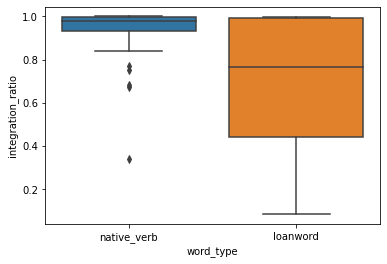

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
word_type_var = 'word_type'
integration_var = 'integration_ratio'
# plt.boxplot([native_verb_integration_ratio, loanword_verb_integration_ratio])
sns.boxplot(x=word_type_var, y=integration_var, data=integration_ratio_data)
plt.show()

Loanwords tend to receive light verbs more often than native verbs.

Is this difference significant?

In [6]:
from scipy.stats import mannwhitneyu
native_verb_integration_ratio = integration_ratio_data[integration_ratio_data.loc[:, word_type_var]=='native_verb'].loc[:, integration_var].values
loanword_verb_integration_ratio = integration_ratio_data[integration_ratio_data.loc[:, word_type_var]=='loanword'].loc[:, integration_var].values
test_stat, p_val = mannwhitneyu(native_verb_integration_ratio, loanword_verb_integration_ratio)
print('difference in integration has test stat %.3f (p=%.3E)'%(test_stat, p_val))

difference in integration has test stat 132.000 (p=2.558E-02)


Weak but significant difference in integration.

### Test integration over time
For all valid words, do we see any consistent change in integration ratio over time?

In [19]:
count_var = 'count'
time_var = 'year'
verb_type_var = 'verb_type'
integrated_rate_var = 'integration_ratio'
time_integration_ratio_data = []
for word_i, data_i in query_counts.groupby(query_var):
    integrated_verb_data_i = data_i[data_i.loc[:, verb_type_var]=='integrated_verb']
    light_verb_data_i = data_i[data_i.loc[:, verb_type_var]=='light_verb']
    if(integrated_verb_data_i.loc[:, count_var].mean() > 0. and light_verb_data_i.loc[:, count_var].mean() > 0):
        integration_ratio_i = integrated_verb_data_i.loc[:, count_var] / (integrated_verb_data_i.loc[:, count_var] + light_verb_data_i.loc[:, 'count'])
        integration_ratio_i = pd.DataFrame(integration_ratio_i).assign(**{time_var : integrated_verb_data_i.loc[:, time_var].values})
        # in case of duplicate years, compute average??
        integration_ratio_i = integration_ratio_i.groupby(time_var).apply(lambda x: x.loc[:, 'count'].mean()).reset_index().rename(columns={0:integrated_rate_var}, inplace=False)
        integration_ratio_i.rename(columns={'count' : integrated_rate_var}, inplace=True)
        integration_ratio_i = integration_ratio_i.assign(**{'word' : word_i})
        time_integration_ratio_data.append(integration_ratio_i)
time_integration_ratio_data = pd.concat(time_integration_ratio_data, axis=0)

In [20]:
# add word type
time_integration_ratio_data = pd.merge(time_integration_ratio_data, combined_word_data.loc[:, ['word', 'word_type']], on='word')
display(time_integration_ratio_data.head())

,year,integration_ratio,word,word_type
0,1980,0.998627,admirar,native_verb
1,1981,0.998646,admirar,native_verb
2,1982,0.998530,admirar,native_verb
3,1983,0.998391,admirar,native_verb
4,1984,0.998332,admirar,native_verb


Using matplotlib backend: <object object at 0x7fe464e5ad80>


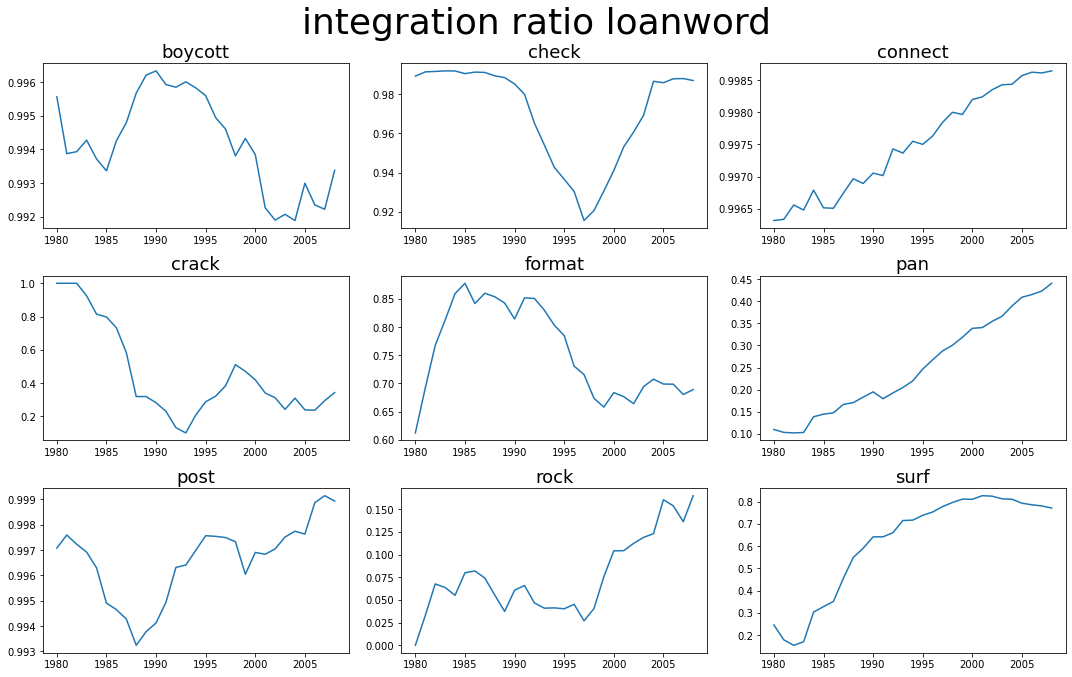

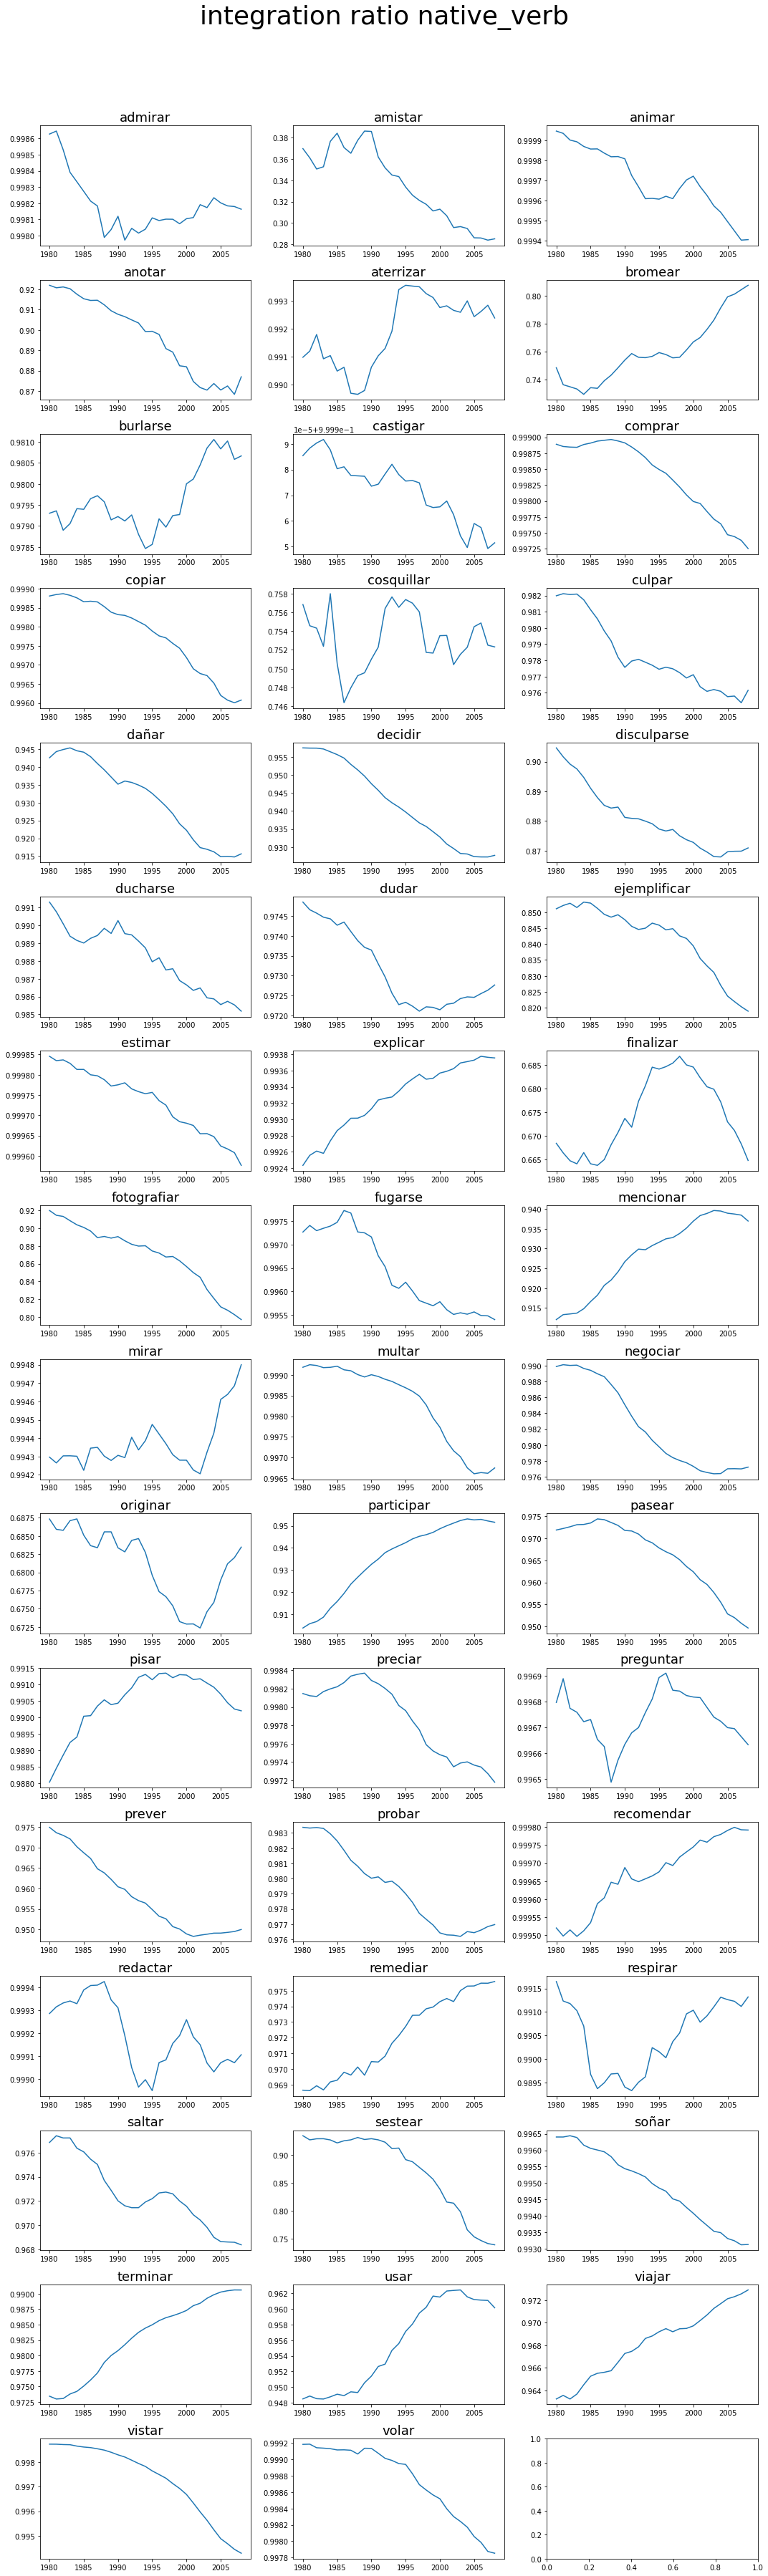

In [21]:
from importlib import reload
import matplotlib
# reload(matplotlib)
%matplotlib
import matplotlib.pyplot as plt
# plt.switch_backend('notebook')
from math import ceil, floor
word_var = 'word'
word_type_var = 'word_type'
time_var = 'year'
integration_var = 'integration_ratio'
for word_type_i, data_i in time_integration_ratio_data.groupby(word_type_var):
    N = data_i.loc[:, word_var].nunique()
    cols = 3
    rows = int(ceil(N / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
    for j, (word_j, data_j) in enumerate(data_i.groupby(word_var)):
        row_j = int(floor(j / cols))
        col_j = j % cols
        ax = axs[row_j, col_j]
        X = data_j.loc[:, time_var].values
        Y = data_j.loc[:, integration_var].values
        ax.plot(X, Y)
        ax.set_title(word_j, fontsize=18)
    plt.tight_layout()
    plt.suptitle(f'integration ratio {word_type_i}', fontsize=36, y=1.04)
    plt.show()

1044    1980
1045    1980
1046    1981
1047    1981
1048    1982
        ... 
1155    2006
1156    2007
1157    2007
1158    2008
1159    2008
Name: year, Length: 116, dtype: int64


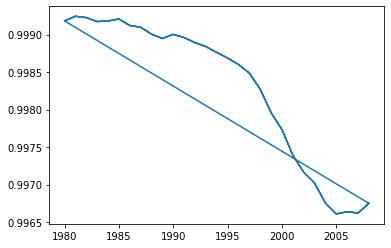

In [13]:
word_i = 'multar'
data_i = time_integration_ratio_data[time_integration_ratio_data.loc[:, 'word']==word_i]
X = data_i.loc[:, 'year']
Y = data_i.loc[:, 'integration_ratio']
print(X)
plt.plot(X, Y)
plt.show()

OK! 

The loanwords tend to show a steady increase in integration, except for a few outliers like `crack` and `format` which may be more technical and therefore require more light verbs for a wider audience.

The native verbs are more bimodal, showing either a steady increase or steady decrease in integration.

Overall: the native verbs show a high amount of integration, and I'm not sure where the differences would be perceptible by native speakers.